# Simulation Experiments

In [1]:
RUN_MODEL = False

In [2]:
import sys
import time
import logging
import warnings
import scipy
import numpy as np
import pandas as pd
import pprint as pp
import gpboost as gpb
import tensorflow as tf
import tensorflow_probability as tfp
import bokeh.plotting as bop
import bokeh.models as bom
import statsmodels.api as sm
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import category_encoders as ce   # https://contrib.scikit-learn.org/category_encoders/
import xgboost as xgb

from tqdm import tqdm
from sklearn import set_config
from sklearn.linear_model import LinearRegression, GammaRegressor
from sklearn.utils import check_random_state
from sklearn.datasets import make_friedman1, make_friedman3
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from bokeh.io import output_notebook, export_svg
from bokeh.layouts import gridplot
from tensorflow.keras import models, layers, optimizers, metrics, losses
from tensorflow.random import set_seed
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from category_encoders.wrapper import NestedCVWrapper
from simulate import make_sim, generate_data
from lmmnn.nn import reg_nn_lmm, calc_b_hat
from glmmnet import DistParams, build_glmmnet, predict_glmmnet, build_baseline_nn

sys.path.append("../")
from utils import (
    split, set_tf_loglevel,
    evaluate_model, evaluate_predictions, 
    plot_from_model, plot_from_predictions, plot_loss_curves, 
    embedding_preproc,
    plot_ridgeline
)

In [3]:
# Package parameters
# Display of sklearn pipelines
set_config(display="diagram")

# Seaborn plotting style
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)

# Suppress tensorflow messages
set_tf_loglevel(logging.FATAL)

# Output bokeh plots to notebook
output_notebook()

# Shorthand for tfp.distributions
tfd = tfp.distributions

Loading BokehJS ...

### Experiment #1: Low Complexity, Gaussian response

In [4]:
# Configure simulation parameters
exp_id = 1                         # experiment id
n_train = 5000                     # number of training observations
n_test = 2500                      # number of test observations
n = n_train + n_test               # total number of observations
n_categories = 100                 # number of categories for the categorical variable
f_structure = "friedman1"          # structure of the fixed effects f(X)
sig2noise = np.array([4, 1, 1])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gaussian"                # distribution of the response variable y
inverse_link = lambda x: x         # inverse of the identity link
cat_dist = "balanced"              # distribution of the categorical variable
random_seed = 42                   # random seed for reproducibility
log_plot = False                   # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network

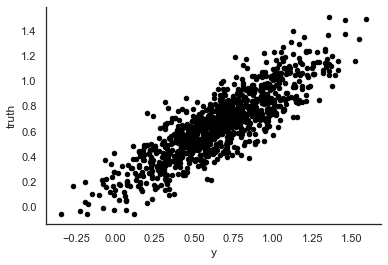

In [5]:
# Generate data
# Generate the fixed effects features X and f(X)
# Doc: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html
if (f_structure == "friedman1"):
    # Out of the n_features features, only 5 are actually used to compute y.
    # The remaining features are independent of y.
    X, f_X = make_friedman1(n_samples=n, n_features=10, noise=0.0, random_state=random_seed)
elif (f_structure == "friedman3"):
    X, f_X = make_friedman3(n_samples=n, noise=0.0, random_state=random_seed)

# Simulate random effects and therefore the response variable y
X, y, truth, Zu = make_sim(X, f_X, n_categories, sig2noise, y_dist, inverse_link, cat_dist, random_seed)

# Plot y truth (i.e. the conditional mean) against y observed
# The smaller the noise component, the closer the points follow a straight line
_ = pd.DataFrame({"y": y[:1000], "truth": truth[:1000]}).plot.scatter(x="y", y="truth", color="black")

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = split(X, y, n_train)

# Conditional mean true values (unobservable in practice)
y_true_train = truth[:n_train]
y_true_test = truth[n_train:]

In [7]:
X_train.shape, X_test.shape

((5000, 11), (2500, 11))

In [8]:
# Combine X, y, and truth into a dataframe and save to files
train_data = pd.concat([
    X_train.reset_index(drop=True), 
    pd.DataFrame(y_train, columns=["y"]), 
    pd.DataFrame(y_true_train, columns=["y_true"])], axis=1)
test_data = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y_test, columns=["y"]),
    pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)

path = f"data/experiment_{exp_id}"
train_data.to_csv(f"{path}/train_data.csv", index=False)
test_data.to_csv(f"{path}/test_data.csv", index=False)

In [9]:
# Print summary statistics of the data
hicard_var = "category"
x_num = [col for col in X.columns if col not in hicard_var]
X[x_num].describe().transpose()

count      mean       std       min       25%       50%       75%  \
X1   7500.0  0.497615  0.288852  0.000125  0.248998  0.496073  0.749031   
X2   7500.0  0.494521  0.288870  0.000017  0.241848  0.494511  0.742734   
X3   7500.0  0.501841  0.287485  0.000012  0.251606  0.501669  0.749772   
X4   7500.0  0.499331  0.288483  0.000008  0.249689  0.500278  0.748632   
X5   7500.0  0.500825  0.288590  0.000135  0.252035  0.502506  0.753344   
X6   7500.0  0.506034  0.289164  0.000047  0.258761  0.505642  0.761703   
X7   7500.0  0.501282  0.285492  0.000006  0.254993  0.501586  0.744931   
X8   7500.0  0.496218  0.288666  0.000053  0.248826  0.494834  0.748937   
X9   7500.0  0.501712  0.287811  0.000110  0.251896  0.502645  0.750863   
X10  7500.0  0.498679  0.287630  0.000270  0.249869  0.498534  0.746239   

          max  
X1   0.999805  
X2   0.999789  
X3   0.999957  
X4   0.999901  
X5   0.999841  
X6   0.999875  
X7   0.999972  
X8   0.999824  
X9   0.999925  
X10  0.999786

In [10]:
pd.DataFrame(y).describe().transpose()

count      mean       std       min       25%       50%       75%  \
0  7500.0  0.657592  0.323488 -0.518781  0.434136  0.658003  0.881773   

        max  
0  1.746482

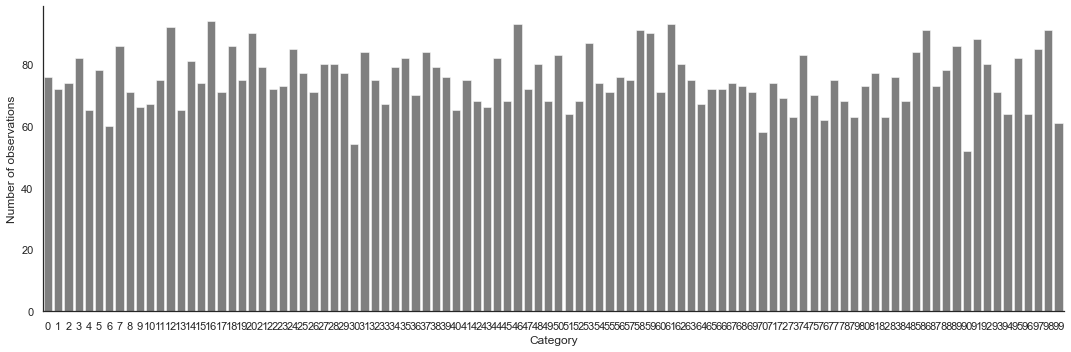

In [11]:
cat_count = X[hicard_var].value_counts()
fig = plt.figure(figsize=(15, 5))
_ = sns.barplot(x=cat_count.index, y=cat_count.values, color="black", alpha=0.5)
plt.ylabel("Number of observations")
plt.xlabel("Category")
plt.tight_layout()

#### GLM

In [12]:
ignore_cat_encoder = make_column_transformer(
    ("drop", [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
GLM_ignore_cat = make_pipeline(ignore_cat_encoder, LinearRegression())
# Apply the pipeline to the dataframe for prediction
GLM_ignore_cat.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('linearregression', LinearRegression())])

In [13]:
train_scores = dict()
test_scores = dict()

print("> In-sample performance")
train_scores["GLM_ignore_cat"] = evaluate_model(GLM_ignore_cat, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GLM_ignore_cat"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GLM_ignore_cat"] = evaluate_model(GLM_ignore_cat, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GLM_ignore_cat"])

> In-sample performance
{'CRPS': 0.14310900069846105,
 'MAE': 0.20262877204739305,
 'MedAE': 0.16936067787763598,
 'MedPE': 0.24174006647096186,
 'NLL': 0.048874104326739144,
 'R2': 0.3799743159135275,
 'RMSE': 0.2540905882539191,
 'RMSE_avg': 0.15385731178238027,
 'RMSE_avg_weighted': 0.15326304978025115}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.14272557899715393,
 'MAE': 0.2016853331178287,
 'MedAE': 0.1677761073170412,
 'MedPE': 0.24126061659871767,
 'NLL': 0.04484974105461321,
 'R2': 0.3931008214973465,
 'RMSE': 0.25307009022743493,
 'RMSE_avg': 0.16212135260176963,
 'RMSE_avg_weighted': 0.16319322865230174}


Observe that errors are quite large w.r.t. the distribution of the response variable. The model does not appear to overfit.

In [14]:
p = plot_from_model(GLM_ignore_cat, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

In [15]:
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first"), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
GLM_one_hot = make_pipeline(one_hot_encoder, LinearRegression())
GLM_one_hot.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('linearregression', LinearRegression())])

In [16]:
print("> In-sample performance")
train_scores["GLM_one_hot"] = evaluate_model(GLM_one_hot, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GLM_one_hot"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GLM_one_hot"] = evaluate_model(GLM_one_hot, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GLM_one_hot"])

> In-sample performance
{'CRPS': 0.11416816856294194,
 'MAE': 0.16139807514282584,
 'MedAE': 0.13662306707797053,
 'MedPE': 0.19826416493588334,
 'NLL': -0.17770528927772133,
 'R2': 0.6059010121589711,
 'RMSE': 0.20257525689624756,
 'RMSE_avg': 9.937147130028223e-07,
 'RMSE_avg_weighted': 9.332011506174265e-07}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.1123245565498542,
 'MAE': 0.15872510471813694,
 'MedAE': 0.13316205724681376,
 'MedPE': 0.1901643331680208,
 'NLL': -0.19154578461882665,
 'R2': 0.6217438438442859,
 'RMSE': 0.19979082838036155,
 'RMSE_avg': 0.050725327017840674,
 'RMSE_avg_weighted': 0.04982970432760635}


In [17]:
p = plot_from_model(GLM_one_hot, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

In [18]:
# Apply a cross-validated version of GLMM encoding
# Docs: https://contrib.scikit-learn.org/category_encoders/
GLMM_encoder = make_column_transformer(
    # https://contrib.scikit-learn.org/category_encoders/wrapper.html
    (NestedCVWrapper(ce.glmm.GLMMEncoder(), cv=KFold(n_splits=5)), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
GLM_GLMM_enc = make_pipeline(GLMM_encoder, LinearRegression())
GLM_GLMM_enc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nestedcvwrapper',
                                                  NestedCVWrapper(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                                                  feature_encoder=GLMMEncoder()),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('linearregression', LinearRegression())])

In [19]:
# Check how the GLMMencoder works
# Docs: https://contrib.scikit-learn.org/category_encoders/_modules/category_encoders/wrapper.html#NestedCVWrapper.transform
# https://contrib.scikit-learn.org/category_encoders/_modules/category_encoders/glmm.html#GLMMEncoder
GLMM_encodings = pd.DataFrame({
    "category": X_train[hicard_var].values,
    "encoding": NestedCVWrapper(ce.GLMMEncoder(), cv=KFold(n_splits=5)).fit_transform(X_train["category"], y_train).values.ravel(),
})
GLMM_encodings

category  encoding
0          51  0.340667
1          92 -0.002120
2          14  0.234305
3          71 -0.032545
4          60 -0.132732
...       ...       ...
4995       48 -0.150653
4996       57  0.058180
4997       38 -0.122347
4998       79 -0.027919
4999       96 -0.162064

[5000 rows x 2 columns]

In [20]:
# Different values for different folds (on the training set)
GLMM_encodings[GLMM_encodings["category"] == 51].value_counts()

category  encoding
51        0.265839    12
          0.340667    12
          0.316554     7
          0.273471     6
          0.280705     5
dtype: int64

In [21]:
# Plot GLMM encodings vs true random effects
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Encodings", width=400, height=400)
p.add_layout(bom.Title(text="Model: GLMM encodings", text_font_style="italic"), "above")
GLMM_encodings = GLMM_encoder.named_transformers_["nestedcvwrapper"].transform(X_train[hicard_var])
p.circle(Zu[:n_train], GLMM_encodings.values.ravel(), color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

The linear shape of the plot above suggests that the GLMM encodings were able to capture the random effects very well - as one would expect given that the random effects signal is reasonably strong.

In [22]:
print("> In-sample performance")
train_scores["GLM_GLMM_enc"] = evaluate_model(GLM_GLMM_enc, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GLM_GLMM_enc"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GLM_GLMM_enc"] = evaluate_model(GLM_GLMM_enc, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GLM_GLMM_enc"])

> In-sample performance
{'CRPS': 0.11534203442830271,
 'MAE': 0.1633558920515475,
 'MedAE': 0.13756463694523974,
 'MedPE': 0.201515837825817,
 'NLL': -0.16709453476883912,
 'R2': 0.5974482641242197,
 'RMSE': 0.20473617744099532,
 'RMSE_avg': 0.030397940842192234,
 'RMSE_avg_weighted': 0.02962025935107252}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.11397651502660888,
 'MAE': 0.161099899041167,
 'MedAE': 0.13783489081702643,
 'MedPE': 0.19518101079580505,
 'NLL': -0.1782191517351888,
 'R2': 0.6115265243757837,
 'RMSE': 0.20247118781780296,
 'RMSE_avg': 0.06045183469225832,
 'RMSE_avg_weighted': 0.05976245049744218}


In [23]:
p = plot_from_model(GLM_GLMM_enc, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

We don't observe much improvement over the one-hot encoded model, most likely due to the restrictive structure of GLM in modelling the highly nonlinear relationship in `friedman1` data.

#### GBM

In [24]:
GBM = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_seed)
GBM_ignore_cat = make_pipeline(ignore_cat_encoder, GBM)
GBM_ignore_cat.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              ena...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=2, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, ...))])

In [25]:
print("> In-sample performance")
train_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_ignore_cat"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GBM_ignore_cat"])

> In-sample performance
{'CRPS': 0.1281124350846384,
 'MAE': 0.18075567940160472,
 'MedAE': 0.15133750876617064,
 'MedPE': 0.21501249750919713,
 'NLL': -0.06082665959372253,
 'R2': 0.5021198550405592,
 'RMSE': 0.22769114562822929,
 'RMSE_avg': 0.148274240164422,
 'RMSE_avg_weighted': 0.14779537393633335}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.13243269293283091,
 'MAE': 0.18759429956744747,
 'MedAE': 0.15912884162957902,
 'MedPE': 0.2242994334501887,
 'NLL': -0.03154899347579817,
 'R2': 0.4790962883487093,
 'RMSE': 0.23445595669197514,
 'RMSE_avg': 0.16034502481725862,
 'RMSE_avg_weighted': 0.1609900727892125}


Again, errors are quite large w.r.t. the distribution of the response variable.

In order to prevent overfitting, the default hyperparameters have been (manually) adjusted such that the training and validation results are comparable. No extensive/systematic hyperparameter search has been performed.

In [26]:
p = plot_from_model(GBM_ignore_cat, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

In [27]:
GBM_one_hot = make_pipeline(one_hot_encoder, GBM)
GBM_one_hot.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_byno...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=2, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, ...))])

In [28]:
print("> In-sample performance")
train_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_one_hot"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GBM_one_hot"])

> In-sample performance
{'CRPS': 0.12065506502236965,
 'MAE': 0.17100201169366364,
 'MedAE': 0.14314922729304175,
 'MedPE': 0.2031975439357439,
 'NLL': -0.12420714707816233,
 'R2': 0.5613953664588784,
 'RMSE': 0.21370778659502337,
 'RMSE_avg': 0.11617693861093174,
 'RMSE_avg_weighted': 0.1145791590987619}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.12491198511560449,
 'MAE': 0.17786349042267252,
 'MedAE': 0.15320779735139545,
 'MedPE': 0.21709161123367943,
 'NLL': -0.09350984308994433,
 'R2': 0.539808130118387,
 'RMSE': 0.22036976879361492,
 'RMSE_avg': 0.129886008722333,
 'RMSE_avg_weighted': 0.13091323292442444}


In [29]:
p = plot_from_model(GBM_one_hot, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

In [30]:
# Apply a cross-validated version of GLMM encoding
GBM_GLMM_enc = make_pipeline(GLMM_encoder, GBM)
GBM_GLMM_enc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nestedcvwrapper',
                                                  NestedCVWrapper(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                                                  feature_encoder=GLMMEncoder()),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree'...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=2, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, ...))])

In [31]:
print("> In-sample performance")
train_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_GLMM_enc"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GBM_GLMM_enc"])

> In-sample performance
{'CRPS': 0.09979870388519771,
 'MAE': 0.14124056067854698,
 'MedAE': 0.11830239524650843,
 'MedPE': 0.1704138480999885,
 'NLL': -0.31125734429389423,
 'R2': 0.6982804311876434,
 'RMSE': 0.17724968734391958,
 'RMSE_avg': 0.03401761319913957,
 'RMSE_avg_weighted': 0.03375052499121346}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.10231475798287837,
 'MAE': 0.14523208102136898,
 'MedAE': 0.12317272986804373,
 'MedPE': 0.17640773873178198,
 'NLL': -0.28766162279517155,
 'R2': 0.6878949120204665,
 'RMSE': 0.18148175459097324,
 'RMSE_avg': 0.058676416751631474,
 'RMSE_avg_weighted': 0.059086801016106}


In [32]:
p = plot_from_model(GBM_GLMM_enc, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

In [33]:
pd.DataFrame(test_scores).transpose()

MAE     MedAE     MedPE      RMSE        R2  RMSE_avg  \
GLM_ignore_cat  0.201685  0.167776  0.241261  0.253070  0.393101  0.162121   
GLM_one_hot     0.158725  0.133162  0.190164  0.199791  0.621744  0.050725   
GLM_GLMM_enc    0.161100  0.137835  0.195181  0.202471  0.611527  0.060452   
GBM_ignore_cat  0.187594  0.159129  0.224299  0.234456  0.479096  0.160345   
GBM_one_hot     0.177863  0.153208  0.217092  0.220370  0.539808  0.129886   
GBM_GLMM_enc    0.145232  0.123173  0.176408  0.181482  0.687895  0.058676   

                RMSE_avg_weighted      CRPS       NLL  
GLM_ignore_cat           0.163193  0.142726  0.044850  
GLM_one_hot              0.049830  0.112325 -0.191546  
GLM_GLMM_enc             0.059762  0.113977 -0.178219  
GBM_ignore_cat           0.160990  0.132433 -0.031549  
GBM_one_hot              0.130913  0.124912 -0.093510  
GBM_GLMM_enc             0.059087  0.102315 -0.287662

The high validation error with `GBM_one_hot` is likely due to the model overfitting to the large number of categories. Trees are known to be tricked by such variables.

The flatter shape (compared to the 45 degree line) in the predictions vs truth plot for GBM with GLMM encoding for both training and validation shows that the encoding does not cause much overfitting. The flatter shape means that there is still the effect of cross-subsidisation between the categories.

#### NN with Entity Embeddings

In [34]:
# Preprocess the data
ct_nn = make_column_transformer(
    (ce.ordinal.OrdinalEncoder(handle_unknown="value"), [hicard_var]), # "value" encodes unknown categories as "-1"
    (MinMaxScaler(feature_range=(0, 1)), x_num),
)
X_train_ct = ct_nn.fit_transform(X_train)
X_test_ct = ct_nn.transform(X_test)

# Convert to dataframes
colnames = [hicard_var] + x_num
X_train_ct = pd.DataFrame(X_train_ct, columns=colnames)
X_test_ct = pd.DataFrame(X_test_ct, columns=colnames)

# Convert dataframe to lists to feed into Keras model
X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])

[category] cardinality: 100 and embedding dim: 3
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



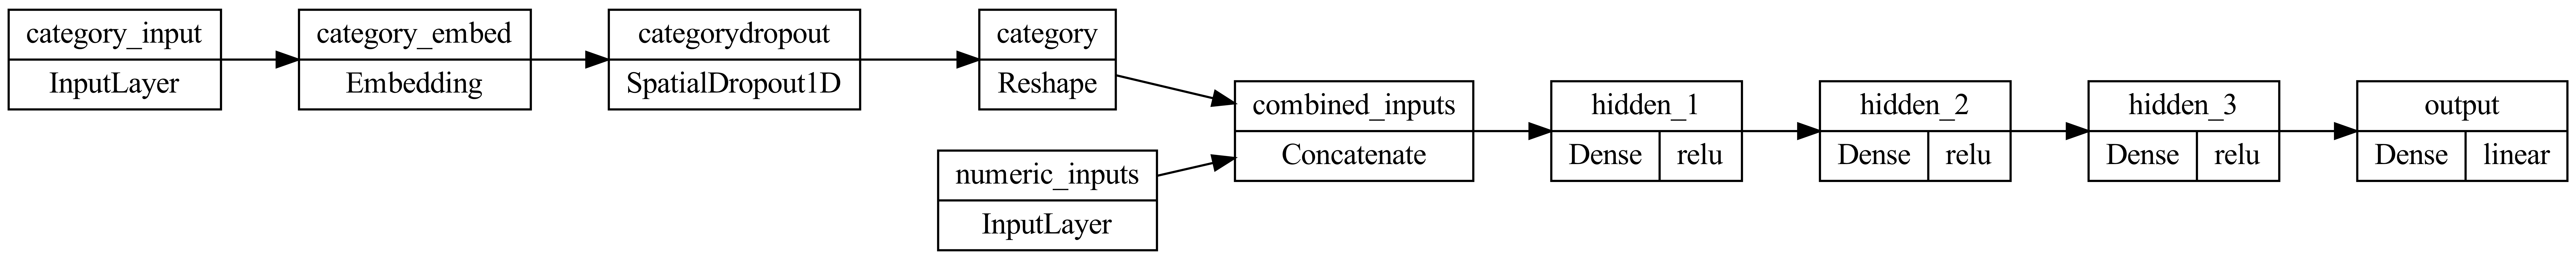

In [35]:
NN_ee = build_baseline_nn(X_train_ct, print_embeddings=True, random_state=random_seed, cat_vars=[hicard_var], num_vars=x_num)
plot_model(NN_ee, dpi=600, show_layer_activations=True, rankdir="LR")

In [36]:
NN_ee.count_params()

3821

In [37]:
n_runs = 10

# Define training parameters
epochs = 500
patience = 10
batch_size = 256
es = EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss", verbose=2)

if RUN_MODEL:
    for run in tqdm(range(n_runs)):
        NN_ee = build_baseline_nn(X_train_ct, print_embeddings=False, random_state=random_seed)
        hist = NN_ee.fit(
            (tuple(X_embed_train), X_train_ct[x_num]), y_train, validation_split=0.2, 
            epochs=epochs, callbacks=[es], batch_size=batch_size, verbose=0)
        hist = hist.history
        # Save model and history
        NN_ee.save(f"models/experiment_{exp_id}/NN_ee_{run}.h5")
        np.save(f"models/experiment_{exp_id}/NN_ee_{run}_hist.npy", hist)

In [38]:
# Load saved models
NN_ee_models = []
NN_ee_train_scores = []
NN_ee_test_scores = []
for run in range(n_runs):
    NN_ee = models.load_model(f"models/experiment_{exp_id}/NN_ee_{run}.h5")
    y_pred_train = NN_ee.predict((tuple(X_embed_train), X_train_ct[x_num])).flatten()
    y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
    train_score = evaluate_predictions(y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist)
    test_score = evaluate_predictions(y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist)
    
    NN_ee_models.append(NN_ee)
    NN_ee_train_scores.append(train_score)
    NN_ee_test_scores.append(test_score)

  1/157 [..............................] - ETA: 31s

2022-11-06 00:47:47.656469: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


79/79 [==============================] - 0s 2ms/step


In [39]:
# Average the scores
train_scores["NN_ee"] = dict(pd.DataFrame(NN_ee_train_scores).mean())
test_scores["NN_ee"] = dict(pd.DataFrame(NN_ee_test_scores).mean())

In [40]:
print("> In-sample performance")
pp.pprint(train_scores["NN_ee"])
print("-" * 80)
print("> Out-of-sample performance")
pp.pprint(test_scores["NN_ee"])

> In-sample performance
{'CRPS': 0.09621038257297387,
 'MAE': 0.13544293070569197,
 'MedAE': 0.11307047268753749,
 'MedPE': 0.16570098811063613,
 'NLL': -0.34754108831813924,
 'R2': 0.7193107341564207,
 'RMSE': 0.17094725602354668,
 'RMSE_avg': 0.03428424321622166,
 'RMSE_avg_weighted': 0.033544536944055875}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.10132022410864772,
 'MAE': 0.1429993649913884,
 'MedAE': 0.12038888451028609,
 'MedPE': 0.17526375003527814,
 'NLL': -0.295778422459712,
 'R2': 0.6928744945562985,
 'RMSE': 0.18002141120196025,
 'RMSE_avg': 0.05711041833718124,
 'RMSE_avg_weighted': 0.054830946317865795}


In [41]:
p = plot_from_predictions(
    y_pred_train=y_pred_train,
    y_train=y_true_train,
    y_pred_test=y_pred_test,
    y_test=y_true_test,
    log_scale=log_plot,
)

In [42]:
# Extract embeddings from the fitted neural network model
embeddings = NN_ee.get_layer(f"{hicard_var}_embed").get_weights()[0]
embeddings = pd.DataFrame(embeddings, columns=["embedding_" + str(i) for i in range(embeddings.shape[1])])
oe = ct_nn.named_transformers_["ordinalencoder"]
categories = np.array(oe.category_mapping[0]["mapping"])[:-1]
embeddings = pd.concat([pd.DataFrame(categories, columns=[hicard_var]), embeddings], axis=1)
embeddings

category  embedding_0  embedding_1  embedding_2
0          1    -0.035191    -0.046968     0.013972
1          2     0.214817    -0.092599    -0.116322
2          3    -0.018121    -0.039443    -0.017386
3          4     0.130001    -0.132101    -0.106364
4          5     0.053573     0.009556     0.017114
..       ...          ...          ...          ...
95        96    -0.093428     0.008742     0.068220
96        97     0.018989    -0.026292     0.034546
97        98     0.063450    -0.068197    -0.118907
98        99     0.023066     0.006617     0.022023
99       100     0.032761    -0.135599    -0.109394

[100 rows x 4 columns]

#### GBM with Entity Embeddings

In [43]:
X_train_ee = pd.merge(X_train_ct, embeddings, on="category", how="left").drop("category", axis=1)
X_test_ee = pd.merge(X_test_ct, embeddings, on="category", how="left").drop("category", axis=1)

In [44]:
GBM_ee = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_seed)
GBM_ee.fit(X_train_ee, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [45]:
print("> In-sample performance")
train_scores["GBM_ee"] = evaluate_model(GBM_ee, X_train_ee, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_ee"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GBM_ee"] = evaluate_model(GBM_ee, X_test_ee, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GBM_ee"])

> In-sample performance
{'CRPS': 0.11889800851984944,
 'MAE': 0.1683694626515984,
 'MedAE': 0.14222798418773913,
 'MedPE': 0.1992538334184015,
 'NLL': -0.13804480809049702,
 'R2': 0.5733674610149908,
 'RMSE': 0.21077093711459197,
 'RMSE_avg': 0.11447776987317092,
 'RMSE_avg_weighted': 0.1144463564818799}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.12238628519241658,
 'MAE': 0.17391301644486956,
 'MedAE': 0.14723381767269228,
 'MedPE': 0.21112851946876746,
 'NLL': -0.11307047235660411,
 'R2': 0.5574638073412048,
 'RMSE': 0.21610108264383512,
 'RMSE_avg': 0.12727413755966516,
 'RMSE_avg_weighted': 0.1286171018682}


In [46]:
p = plot_from_model(GBM_ee, X_train_ee, y_true_train, X_test_ee, y_true_test, log_scale=log_plot)

In [47]:
pd.DataFrame(test_scores).transpose()

MAE     MedAE     MedPE      RMSE        R2  RMSE_avg  \
GLM_ignore_cat  0.201685  0.167776  0.241261  0.253070  0.393101  0.162121   
GLM_one_hot     0.158725  0.133162  0.190164  0.199791  0.621744  0.050725   
GLM_GLMM_enc    0.161100  0.137835  0.195181  0.202471  0.611527  0.060452   
GBM_ignore_cat  0.187594  0.159129  0.224299  0.234456  0.479096  0.160345   
GBM_one_hot     0.177863  0.153208  0.217092  0.220370  0.539808  0.129886   
GBM_GLMM_enc    0.145232  0.123173  0.176408  0.181482  0.687895  0.058676   
NN_ee           0.142999  0.120389  0.175264  0.180021  0.692874  0.057110   
GBM_ee          0.173913  0.147234  0.211129  0.216101  0.557464  0.127274   

                RMSE_avg_weighted      CRPS       NLL  
GLM_ignore_cat           0.163193  0.142726  0.044850  
GLM_one_hot              0.049830  0.112325 -0.191546  
GLM_GLMM_enc             0.059762  0.113977 -0.178219  
GBM_ignore_cat           0.160990  0.132433 -0.031549  
GBM_one_hot              0.130913  0.124912 -0.093510  
GBM_GLMM_enc             0.059087  0.102315 -0.287662  
NN_ee                    0.054831  0.101320 -0.295778  
GBM_ee                   0.128617  0.122386 -0.113070

#### (Generalised) Linear Mixed Effects Models

In [48]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


In [49]:
y_pred_train_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_train.csv").values.reshape(-1)
y_pred_test_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_test.csv").values.reshape(-1)
re_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_re.csv").values.reshape(-1)
sigma_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_sigma.csv").values.reshape(-1)

In [50]:
sigma_brms

array([0.2048248])

In [51]:
# Evaluate model performance
# Training set
print("> In-sample performance")
train_scores["GLMM"] = evaluate_predictions(
    y_train, y_pred_train_brms, categories=X_train[hicard_var], likelihood=y_dist,
    loc=y_pred_train_brms, scale=sigma_brms,
)
pp.pprint(train_scores["GLMM"])

# Validation set
print("-" * 80)
print("> Out-of-sample performance")
test_scores["GLMM"] = evaluate_predictions(
    y_test, y_pred_test_brms, categories=X_test[hicard_var], likelihood=y_dist,
    loc=y_pred_test_brms, scale=sigma_brms,
)
pp.pprint(test_scores["GLMM"])

> In-sample performance
{'CRPS': 0.11414328802029863,
 'MAE': 0.16139467722563117,
 'MedAE': 0.1360819913623484,
 'MedPE': 0.19750830458236235,
 'NLL': -0.1778699020502446,
 'R2': 0.6061312128600006,
 'RMSE': 0.20251608422722592,
 'RMSE_avg': 0.005710983146475842,
 'RMSE_avg_weighted': 0.0055383640325953444}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.11242150629680006,
 'MAE': 0.15881534277526801,
 'MedAE': 0.13272944792169422,
 'MedPE': 0.19011166975197608,
 'NLL': -0.19042070911821218,
 'R2': 0.6213335594131721,
 'RMSE': 0.19989915292328841,
 'RMSE_avg': 0.051170879882879605,
 'RMSE_avg_weighted': 0.0505267609012017}


In [52]:
p = plot_from_predictions(y_pred_train_brms, y_true_train, y_pred_test_brms, y_true_test, log_scale=log_plot)

In [53]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.add_layout(bom.Title(text="Model: GLMM", text_font_style="italic"), "above")
rev = np.array([float(re_brms[g]) for g in X_train[hicard_var]])
p.circle(Zu[:n_train], rev, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

The linear shape of the plot above suggests that the GLMM (here an LMM) were able to capture the random effects extremely well - better than the GLMM encodings which were computed based on an intercept model. Here the relationship between the predictors and the response is accurately captured.

Again, note that the line does not necessarily match with the `y = x` line as the `ground truth` numbers are from the raw simulated values of RE prior to normalisation (required to achieve the desired signal-to-noise).

#### GPBoost
Installation seemed to work but I kept getting errors from any attempt to call a function from the package. The temporary workaround therefore is to use the R package and read in the predictions.

In [54]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


In [55]:
y_pred_train_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_train.csv").values.reshape(-1)
y_pred_test_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_test.csv").values.reshape(-1)
re_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_re.csv").values.reshape(-1)
scale_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_scale.csv").values.reshape(-1)

In [56]:
# Evaluate model performance
# Training set
print("> In-sample performance")
train_scores["GPBoost"] = evaluate_predictions(
    y_train, y_pred_train_gpb, categories=X_train[hicard_var], likelihood=y_dist,
    loc=y_pred_train_gpb, scale=np.sqrt(scale_gpb),
)
pp.pprint(train_scores["GPBoost"])

# Validation set
print("-" * 80)
print("> Out-of-sample performance")
test_scores["GPBoost"] = evaluate_predictions(
    y_test, y_pred_test_gpb, categories=X_test[hicard_var], likelihood=y_dist,
    loc=y_pred_test_gpb, scale=np.sqrt(scale_gpb),
)
pp.pprint(test_scores["GPBoost"])

> In-sample performance
{'CRPS': 0.10897228971926635,
 'MAE': 0.15416212242919664,
 'MedAE': 0.13071627853944984,
 'MedPE': 0.18897401959535437,
 'NLL': -0.2242019798745941,
 'R2': 0.6409279921394511,
 'RMSE': 0.19336350677633904,
 'RMSE_avg': 0.004976766741781084,
 'RMSE_avg_weighted': 0.00484973692481012}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.11331694146361308,
 'MAE': 0.15990417212872496,
 'MedAE': 0.13447217945194545,
 'MedPE': 0.19871698086501186,
 'NLL': -0.18379879636401628,
 'R2': 0.6174308009739478,
 'RMSE': 0.200926651169445,
 'RMSE_avg': 0.050962464817209514,
 'RMSE_avg_weighted': 0.050676318912964764}


In [57]:
p = plot_from_predictions(y_pred_train_gpb, y_true_train, y_pred_test_gpb, y_true_test, log_scale=log_plot)

In [58]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.add_layout(bom.Title(text="Model: GPBoost", text_font_style="italic"), "above")
p.circle(Zu[:n_train], re_gpb, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

We see a significant improvement in performance compared to the linear counterpart of GPBoost (i.e. plain GLMM). Again this shows a non-linear structure is required to model the non-linearity in the simulated data.

GPBoost, however, performs comparably with GBM with GLMM encoding, highlighting the benefit of using the latter (similar performance at a smaller computational cost). We do note that GBM with GLMM encoding tends to overfit a bit to the training data, and therefore may not generalise as well as GPBoost when exposed to data with a significant amount of noise or a shift in distribution.

#### LMMNN

In [59]:
# Parameters (adapted from LMMNN demo notebooks)
x_cols = [col for col in X_train_ct.columns if col not in [hicard_var]]
batch = 100
epochs = 500
patience = 10
qs = [n_categories]
q_spatial = None
n_neurons = [64, 32, 16]
dropout = None
activation = "relu"
Z_non_linear = False
Z_embed_dim_pct = 10
mode = "intercepts"
n_sig2bs = 1
n_sig2bs_spatial = 0
est_cors = []
dist_matrix = None
time2measure_dict = None
spatial_embed_neurons = None
resultion = None
verbose = False
log_params = False
idx = None

In [60]:
# Fit model
# LMMNN is 0-indexed
X_train_ct[hicard_var] = X_train_ct[hicard_var].astype(int) - 1
X_test_ct[hicard_var] = X_test_ct[hicard_var].astype(int) - 1
tf.random.set_seed(random_seed)
_, y_pred_train, *_ = reg_nn_lmm(
    X_train_ct.rename(columns={hicard_var: "z0"}), X_train_ct.rename(columns={hicard_var: "z0"}), 
    y_train, y_train, qs, q_spatial, x_cols, batch, epochs, patience, n_neurons, dropout, activation, 
    mode, n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons,
    verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)

tf.random.set_seed(random_seed)
lmmnn, y_pred_test, sigmas, rhos, weibull, hist_lmmnn = reg_nn_lmm(
    X_train_ct.rename(columns={hicard_var: "z0"}), X_test_ct.rename(columns={hicard_var: "z0"}), 
    y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience, n_neurons, dropout, activation, 
    mode, n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons,
    verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)

79/79 [==============================] - 0s 2ms/step


In [61]:
print(sigmas) # --> (sigma2_e, sigma2_u, [])

(0.025062392, [0.025219856], [])


In [62]:
plot_loss_curves(hist_lmmnn)

Figure(id='5246', ...)

In [63]:
# Evaluate model performance
# Training set
print("> In-sample performance")
train_scores["LMMNN"] = evaluate_predictions(
    y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist,
    loc=y_pred_train, scale=np.sqrt(sigmas[0]),
)
pp.pprint(train_scores["LMMNN"])

# Validation set
print("-" * 80)
print("> Out-of-sample performance")
test_scores["LMMNN"] = evaluate_predictions(
    y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist,
    loc=y_pred_test, scale=np.sqrt(sigmas[0]),
)
pp.pprint(test_scores["LMMNN"])

> In-sample performance
{'CRPS': 0.09308535481378737,
 'MAE': 0.1313615072012311,
 'MedAE': 0.11032447799790542,
 'MedPE': 0.16652925450924808,
 'NLL': -0.38188107548727146,
 'R2': 0.7389138705277851,
 'RMSE': 0.1648829080785202,
 'RMSE_avg': 0.003155803174119186,
 'RMSE_avg_weighted': 0.0030645096572647504}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.09760980547569542,
 'MAE': 0.13783342587597627,
 'MedAE': 0.11792307195582899,
 'MedPE': 0.17264694450011714,
 'NLL': -0.329810860688764,
 'R2': 0.7176430807004439,
 'RMSE': 0.17261628376984045,
 'RMSE_avg': 0.04338135653778629,
 'RMSE_avg_weighted': 0.04311380627991598}


In [64]:
p = plot_from_predictions(y_pred_train, y_true_train, y_pred_test, y_true_test, log_scale=log_plot)

In [65]:
sig2e_est, sig2b_ests, *_ = sigmas
u_hat = calc_b_hat(
    X_train_ct.rename(columns={hicard_var: "z0"}), y_train, y_pred_train, qs=[n_categories], q_spatial=None, 
    sig2e=sig2e_est, sig2bs=sig2b_ests, sig2bs_spatial=None,
    Z_non_linear=False, model=lmmnn, ls=None, mode=mode, rhos=None, 
    est_cors=est_cors, dist_matrix=None, weibull_ests=None)

In [66]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
re_lmmnn = np.array([float(u_hat[g]) for g in X_train_ct[hicard_var]])
p.circle(Zu[:n_train], re_lmmnn, color="#9f86c0")
bop.show(p)

#### LMMNet

In [67]:
one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
X_test_ct_ohe = one_hot.transform(X_test_ct)
cardinality = len(one_hot.category_mapping[0]["mapping"].keys()) - 1

In [68]:
n_runs = 10
epochs = 500
n_prediction_samples = 100

if RUN_MODEL:
    for run in tqdm(range(n_runs)):
        lmmnet = build_glmmnet(
            cardinality=cardinality, num_vars=x_num, final_layer_likelihood=y_dist, 
            train_size=X_train.shape[0], random_state=random_seed)
        es = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_loss", verbose=0)
        hist = lmmnet.fit(
            (X_train_ct.drop([hicard_var], axis=1), X_train_ct_ohe.loc[:, X_train_ct_ohe.columns.str.startswith(hicard_var)]), y_train, 
            validation_split=0.2,
            # note: batch_size = 128 (128 or 256 doesn't make a difference, but 256 is faster)
            callbacks=[es], batch_size=256, epochs=epochs, verbose=False)
        hist = hist.history
        # Save history
        np.save(f"models/experiment_{exp_id}/lmmnet_{run}_hist.npy", hist)
        # Model saving does not work with DenseVariational layer, so we'll save the predictions
        y_pred_train = predict_glmmnet(lmmnet, X_train_ct_ohe, hicard_var)
        y_pred_test = predict_glmmnet(lmmnet, X_test_ct_ohe, hicard_var)
        # Save predictions
        np.save(f"models/experiment_{exp_id}/lmmnet_{run}_y_pred_train.npy", y_pred_train)
        np.save(f"models/experiment_{exp_id}/lmmnet_{run}_y_pred_test.npy", y_pred_test)
        # Save dispersion estimates
        phi = lmmnet.get_layer("dist_params").get_weights()
        np.save(f"models/experiment_{exp_id}/lmmnet_{run}_phi.npy", phi[0][0])

In [69]:
# Load predictions
# Evaluate performance
LMMNet_train_scores = []
LMMNet_test_scores = []
for run in range(n_runs):
    y_pred_train = np.load(f"models/experiment_{exp_id}/lmmnet_{run}_y_pred_train.npy")
    y_pred_test = np.load(f"models/experiment_{exp_id}/lmmnet_{run}_y_pred_test.npy")
    phi = np.load(f"models/experiment_{exp_id}/lmmnet_{run}_phi.npy")
    
    # Evaluate model performance
    train_score = evaluate_predictions(
        y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist, loc=y_pred_train, scale=phi)
    test_score = evaluate_predictions(
        y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist, loc=y_pred_test, scale=phi)
    LMMNet_train_scores.append(train_score)
    LMMNet_test_scores.append(test_score)

In [71]:
plot_loss_curves(hist)

Figure(id='6474', ...)

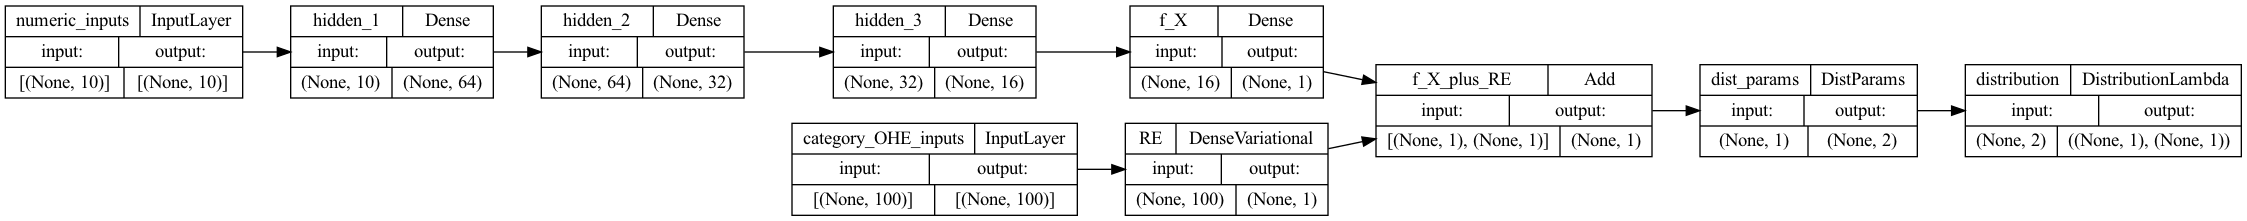

In [72]:
plot_model(lmmnet, rankdir="LR", show_shapes=True, show_layer_names=True)

In [73]:
# Examine the trained parameters
dummy_input = tf.constant(0.) # doesn't matter what this is
model_prior = lmmnet.get_layer("RE")._prior(dummy_input)
model_posterior = lmmnet.get_layer("RE")._posterior(dummy_input)

print("Prior mean:     ", model_prior.mean().numpy()[0])
print("Prior variance: ", model_prior.variance().numpy()[0])
print("Posterior mean: ")
print(model_posterior.mean().numpy())
print("Posterior variance: " )
print(model_posterior.variance().numpy())

# Get the dispersion parameter (here the error variance)
sigma_e = lmmnet.get_layer("dist_params").get_weights()
print(f"Estimated sigma_e: {sigma_e[0][0]:.8f}")

Prior mean:      0.0
Prior variance:  0.022677397
Posterior mean: 
[ 0.29295117  0.00326393  0.24947704 -0.02088748 -0.18800528 -0.04669521
  0.26351032  0.05558364  0.11961187  0.20353001 -0.05818044 -0.08779083
  0.3022364  -0.11579442 -0.19960737  0.03956174 -0.05118812  0.16197172
 -0.09972574  0.12999152  0.19445765  0.0910882   0.04199971 -0.01841659
 -0.18808025  0.11289716 -0.06011871  0.22131501 -0.0896493  -0.03616609
  0.1644485  -0.04758636  0.19724484 -0.10620481 -0.0908664   0.06325003
 -0.14821014  0.23727506  0.03503769 -0.13561365  0.14691433 -0.22723915
 -0.09296124  0.06664389 -0.156153   -0.251962   -0.0252099   0.39923668
 -0.00661302 -0.01227564 -0.20650372 -0.14867653  0.19704285 -0.00108089
 -0.24391407 -0.13924013  0.01052689 -0.07365461 -0.14554034  0.05977091
  0.10117393  0.08523325 -0.25075626  0.04847439 -0.08565698 -0.08817272
 -0.00049184  0.02640534 -0.10474477  0.02470954 -0.13416226 -0.11114182
  0.07227137  0.1402281   0.02365988  0.13657339 -0.11783

In [71]:
p = plot_from_predictions(y_pred_train, y_true_train, y_pred_test, y_true_test, log_scale=log_plot)

In [70]:
# Evaluate model performance
# Average the scores
train_scores["LMMNet"] = dict(pd.DataFrame(LMMNet_train_scores).mean())
test_scores["LMMNet"] = dict(pd.DataFrame(LMMNet_test_scores).mean())

# Training set
print("> In-sample performance")
pp.pprint(train_scores["LMMNet"])
print("-" * 80)
print("> Out-of-sample performance")
pp.pprint(test_scores["LMMNet"])

> In-sample performance
{'CRPS': 0.0949814254215909,
 'MAE': 0.13389034615929216,
 'MedAE': 0.11167675281246447,
 'MedPE': 0.16485625961563993,
 'NLL': -0.3623028359710986,
 'R2': 0.7275035603928541,
 'RMSE': 0.16843348273356934,
 'RMSE_avg': 0.020005400707336175,
 'RMSE_avg_weighted': 0.02020921302115074}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.09870961749473421,
 'MAE': 0.139452042050988,
 'MedAE': 0.11859771272215172,
 'MedPE': 0.17115472141440802,
 'NLL': -0.32332608353241177,
 'R2': 0.7104112481457501,
 'RMSE': 0.17480202709884146,
 'RMSE_avg': 0.046120497218803465,
 'RMSE_avg_weighted': 0.04578272023771359}


In [73]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.add_layout(bom.Title(text="Model: LMMNet", text_font_style="italic"), "above")
# Get the posterior mean of the random effects
u_hat = lmmnet.get_layer("RE").weights[0][:cardinality] # extract the posterior means
re_lmmnet = tf.gather(u_hat, X_train_ct[hicard_var].astype("int")).numpy()
p.circle(Zu[:n_train], re_lmmnet, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

79/79 [==============================] - 0s 3ms/step


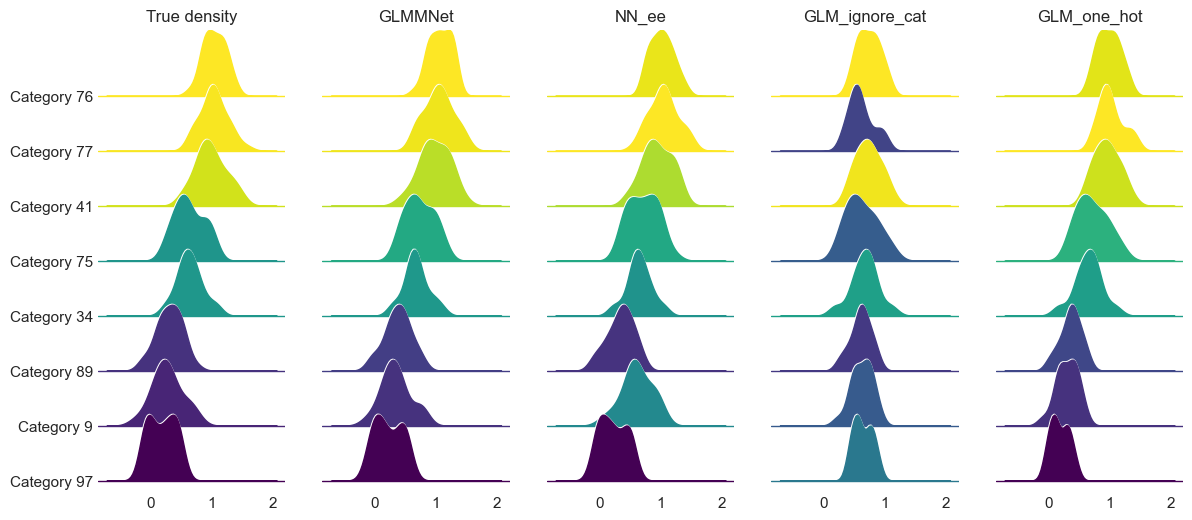

In [77]:
# Code adapted from https://scipython.com/blog/ridgeline-plots-of-monthly-uk-temperatures/
dpi = 100
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(1400/dpi, 600/dpi), dpi=dpi)

ranked_cats = test_data.groupby("category").mean().sort_values("y").index.to_list()
selected_cats = ranked_cats[:3] + ranked_cats[len(ranked_cats)//2:len(ranked_cats)//2+2] + ranked_cats[-3:]
p_min, p_max = y_true_test.min(), y_true_test.max()
plot_ridgeline(X_test["category"], y_true_test, selected_cats, axes[0], "True density")
plot_ridgeline(X_test["category"], y_pred_test, selected_cats, axes[1], "GLMMNet", ylabel=False, p_min=p_min, p_max=p_max)
NN_ee_y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
plot_ridgeline(X_test["category"], NN_ee_y_pred_test, selected_cats, axes[2], "NN_ee", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GLM_ignore_cat.predict(X_test), selected_cats, axes[3], "GLM_ignore_cat", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GLM_one_hot.predict(X_test), selected_cats, axes[4], "GLM_one_hot", ylabel=False, p_min=p_min, p_max=p_max)

plt.show()
# fig.savefig(f"figures/experiment_{exp_id}/ridgeline.pdf")

#### Comparison of Models for Experiment #1

In [71]:
with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(test_scores).transpose())

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.2026 0.1694 0.2417 0.2541 0.3800    0.1539   
GLM_one_hot    0.1614 0.1366 0.1983 0.2026 0.6059    0.0000   
GLM_GLMM_enc   0.1634 0.1376 0.2015 0.2047 0.5974    0.0304   
GBM_ignore_cat 0.1808 0.1513 0.2150 0.2277 0.5021    0.1483   
GBM_one_hot    0.1710 0.1431 0.2032 0.2137 0.5614    0.1162   
GBM_GLMM_enc   0.1412 0.1183 0.1704 0.1772 0.6983    0.0340   
NN_ee          0.1354 0.1131 0.1657 0.1709 0.7193    0.0343   
GBM_ee         0.1684 0.1422 0.1993 0.2108 0.5734    0.1145   
GLMM           0.1614 0.1361 0.1975 0.2025 0.6061    0.0057   
GPBoost        0.1542 0.1307 0.1890 0.1934 0.6409    0.0050   
LMMNN          0.1314 0.1103 0.1665 0.1649 0.7389    0.0032   
LMMNet         0.1339 0.1117 0.1649 0.1684 0.7275    0.0200   

                RMSE_avg_weighted   CRPS     NLL  
GLM_ignore_cat             0.1533 0.1431  0.0489  
GLM_one_hot                0.0000 0.1142 -0.1777  
GLM_GLMM_enc               0.0296 0.1153 -0.1671  
GBM_ignore_cat             0.1478 0.1281 -0.0608  
GBM_one_hot                0.1146 0.1207 -0.1242  
GBM_GLMM_enc               0.0338 0.0998 -0.3113  
NN_ee                      0.0335 0.0962 -0.3475  
GBM_ee                     0.1144 0.1189 -0.1380  
GLMM                       0.0055 0.1141 -0.1779  
GPBoost                    0.0048 0.1090 -0.2242  
LMMNN                      0.0031 0.0931 -0.3819  
LMMNet                     0.0202 0.0950 -0.3623

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.2017 0.1678 0.2413 0.2531 0.3931    0.1621   
GLM_one_hot    0.1587 0.1332 0.1902 0.1998 0.6217    0.0507   
GLM_GLMM_enc   0.1611 0.1378 0.1952 0.2025 0.6115    0.0605   
GBM_ignore_cat 0.1876 0.1591 0.2243 0.2345 0.4791    0.1603   
GBM_one_hot    0.1779 0.1532 0.2171 0.2204 0.5398    0.1299   
GBM_GLMM_enc   0.1452 0.1232 0.1764 0.1815 0.6879    0.0587   
NN_ee          0.1430 0.1204 0.1753 0.1800 0.6929    0.0571   
GBM_ee         0.1739 0.1472 0.2111 0.2161 0.5575    0.1273   
GLMM           0.1588 0.1327 0.1901 0.1999 0.6213    0.0512   
GPBoost        0.1599 0.1345 0.1987 0.2009 0.6174    0.0510   
LMMNN          0.1378 0.1179 0.1726 0.1726 0.7176    0.0434   
LMMNet         0.1395 0.1186 0.1712 0.1748 0.7104    0.0461   

                RMSE_avg_weighted   CRPS     NLL  
GLM_ignore_cat             0.1632 0.1427  0.0448  
GLM_one_hot                0.0498 0.1123 -0.1915  
GLM_GLMM_enc               0.0598 0.1140 -0.1782  
GBM_ignore_cat             0.1610 0.1324 -0.0315  
GBM_one_hot                0.1309 0.1249 -0.0935  
GBM_GLMM_enc               0.0591 0.1023 -0.2877  
NN_ee                      0.0548 0.1013 -0.2958  
GBM_ee                     0.1286 0.1224 -0.1131  
GLMM                       0.0505 0.1124 -0.1904  
GPBoost                    0.0507 0.1133 -0.1838  
LMMNN                      0.0431 0.0976 -0.3298  
LMMNet                     0.0458 0.0987 -0.3233

Note that LMMNN outperforms `NN_ee` (though only by a small margin), suggesting that optimising the network via the (more suitable) mixed model likelihood can provide a benefit.

### Experiment #2

In [72]:
# Configure simulation parameters
exp_id = 2                         # experiment id
sig2noise = np.array([4, 1, 1])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gamma"                   # distribution of the response variable y
inverse_link = np.exp              # inverse of the log link
cat_dist = "balanced"              # distribution of the categorical variable
random_seed = 42 + 4               # random seed for reproducibility
log_plot = True                    # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network (entity embedding model)

In [73]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, n_train=n_train, n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True
)

In [74]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


In [75]:
# Make a function to make life easier for repeated experiments
# Skip all the plotting and just return the table of results
def run_sim_experiment(exp_id, sim_data, y_dist="gaussian", random_state=random_seed):

    # Unpack data
    X_train, y_train, y_true_train = sim_data["train"]
    X_test, y_test, y_true_test = sim_data["test"]
    Zu = sim_data["Zu"]

    # Variable names
    hicard_var = "category"
    x_num = [col for col in X_train.columns if col not in hicard_var]
    colnames = [hicard_var] + x_num

    # Convert numeric to string so they can be recognised by ce.OrdinalEncoder
    X_train[hicard_var] = X_train[hicard_var].astype("str")
    X_test[hicard_var] = X_test[hicard_var].astype("str")

    # Initialise
    train_scores = dict()
    test_scores = dict()
    plots = dict()
    runtimes = dict()
    models = dict()

    # GLM
    # -------------------------------------------------------------------------
    ignore_cat_encoder = make_column_transformer(
        ("drop", [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
    )
    X_train_ic = ignore_cat_encoder.fit_transform(X_train)
    X_test_ic = ignore_cat_encoder.transform(X_test)
    start = time.time()
    if y_dist == "gaussian":
        GLM_ignore_cat = LinearRegression()
        GLM_ignore_cat.fit(X_train_ic, y_train)
        gamma_shape = None # placeholder, will not be read when y_dist == "gaussian"
    elif y_dist == "gamma":
        GLM_ignore_cat = sm.GLM(y_train, X_train_ic, family=sm.families.Gamma(sm.families.links.log())).fit()
        gamma_shape = 1 / GLM_ignore_cat.scale
    end = time.time()
    train_scores["GLM_ignore_cat"] = evaluate_model(
        GLM_ignore_cat, X_train_ic, y_train, categories=X_train[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    test_scores["GLM_ignore_cat"] = evaluate_model(
        GLM_ignore_cat, X_test_ic, y_test, categories=X_test[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    plots["GLM_ignore_cat"] = plot_from_model(GLM_ignore_cat, X_train_ic, y_true_train, X_test_ic, y_true_test, log_scale=log_plot, show=False)
    runtimes["GLM_ignore_cat"] = end - start
    models["GLM_ignore_cat"] = GLM_ignore_cat

    one_hot_encoder = make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
    )
    X_train_ohe = one_hot_encoder.fit_transform(X_train)
    X_test_ohe = one_hot_encoder.transform(X_test)
    start = time.time()
    if y_dist == "gaussian":
        GLM_one_hot = LinearRegression()
        GLM_one_hot.fit(X_train_ohe, y_train)
        gamma_shape = None # placeholder, will not be read when y_dist == "gaussian"
    elif y_dist == "gamma":
        GLM_one_hot = sm.GLM(y_train, X_train_ohe, family=sm.families.Gamma(sm.families.links.log())).fit()
        gamma_shape = 1 / GLM_one_hot.scale
    end = time.time()
    train_scores["GLM_one_hot"] = evaluate_model(
        GLM_one_hot, X_train_ohe, y_train, categories=X_train[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    test_scores["GLM_one_hot"] = evaluate_model(
        GLM_one_hot, X_test_ohe, y_test, categories=X_test[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    plots["GLM_one_hot"] = plot_from_model(GLM_one_hot, X_train_ohe, y_true_train, X_test_ohe, y_true_test, log_scale=log_plot, show=False)
    runtimes["GLM_one_hot"] = end - start
    models["GLM_one_hot"] = GLM_one_hot

    GLMM_encoder = make_column_transformer(
        # https://contrib.scikit-learn.org/category_encoders/wrapper.html
        (NestedCVWrapper(ce.glmm.GLMMEncoder(), cv=KFold(n_splits=5)), [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
    )
    X_train_GLMM_enc = GLMM_encoder.fit_transform(X_train, y_train)
    X_test_GLMM_enc = GLMM_encoder.transform(X_test)
    start = time.time()
    if y_dist == "gaussian":
        GLM_GLMM_enc = LinearRegression()
        GLM_GLMM_enc.fit(X_train_GLMM_enc, y_train)
        gamma_shape = None # placeholder, will not be read when y_dist == "gaussian"
    elif y_dist == "gamma":
        GLM_GLMM_enc = sm.GLM(y_train, X_train_GLMM_enc, family=sm.families.Gamma(sm.families.links.log())).fit()
        gamma_shape = 1 / GLM_GLMM_enc.scale
    end = time.time()
    train_scores["GLM_GLMM_enc"] = evaluate_model(
        GLM_GLMM_enc, X_train_GLMM_enc, y_train, categories=X_train[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    test_scores["GLM_GLMM_enc"] = evaluate_model(
        GLM_GLMM_enc, X_test_GLMM_enc, y_test, categories=X_test[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    plots["GLM_GLMM_enc"] = plot_from_model(GLM_GLMM_enc, X_train_GLMM_enc, y_true_train, X_test_GLMM_enc, y_true_test, log_scale=log_plot, show=False)
    # Plot GLMM encodings vs true random effects
    left, right = Zu.min(), Zu.max()
    span = right - left
    bottom, top = Zu.min() - span * 0.1, Zu.max() + span * 0.1
    p = bop.figure(title="GLMM Encodings", x_axis_label="Ground truth", y_axis_label="GLMM encodings", width=400, height=300,
                   x_range=(left, right), y_range=(bottom, top))
    p.add_layout(bom.Title(text="Model: GLMM encodings", text_font_style="italic"), "above")
    GLMM_encodings = GLMM_encoder.named_transformers_["nestedcvwrapper"].transform(X_train[hicard_var])
    p.circle(Zu[:X_train.shape[0]], GLMM_encodings.values.ravel(), color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GLMM_encodings"] = p
    runtimes["GLM_GLMM_enc"] = end - start
    models["GLM_GLMM_enc"] = GLM_GLMM_enc

    # GBM
    # -------------------------------------------------------------------------
    GBM_ignore_cat = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    start = time.time()
    GBM_ignore_cat.fit(X_train_ic, y_train)
    end = time.time()
    train_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_train_ic, y_train, categories=X_train[hicard_var], likelihood=y_dist)
    test_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_test_ic, y_test, categories=X_test[hicard_var], likelihood=y_dist)
    plots["GBM_ignore_cat"] = plot_from_model(GBM_ignore_cat, X_train_ic, y_true_train, X_test_ic, y_true_test, log_scale=log_plot, show=False)
    runtimes["GBM_ignore_cat"] = end - start
    models["GBM_ignore_cat"] = GBM_ignore_cat

    GBM_one_hot = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    start = time.time()
    GBM_one_hot.fit(X_train_ohe, y_train)
    end = time.time()
    train_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_train_ohe, y_train, categories=X_train[hicard_var], likelihood=y_dist)
    test_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_test_ohe, y_test, categories=X_test[hicard_var], likelihood=y_dist)
    plots["GBM_one_hot"] = plot_from_model(GBM_one_hot, X_train_ohe, y_true_train, X_test_ohe, y_true_test, log_scale=log_plot, show=False)
    runtimes["GBM_one_hot"] = end - start
    models["GBM_one_hot"] = GBM_one_hot

    GBM_GLMM_enc = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    start = time.time()
    GBM_GLMM_enc.fit(X_train_GLMM_enc, y_train)
    end = time.time()
    train_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_train_GLMM_enc, y_train, categories=X_train[hicard_var], likelihood=y_dist)
    test_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_test_GLMM_enc, y_test, categories=X_test[hicard_var], likelihood=y_dist)
    plots["GBM_GLMM_enc"] = plot_from_model(GBM_GLMM_enc, X_train_GLMM_enc, y_true_train, X_test_GLMM_enc, y_true_test, log_scale=log_plot, show=False)
    runtimes["GBM_GLMM_enc"] = end - start
    models["GBM_GLMM_enc"] = GBM_GLMM_enc

    # NN with entity embeddings
    # -------------------------------------------------------------------------
    ct_nn = make_column_transformer(
        (ce.ordinal.OrdinalEncoder(handle_unknown="value"), [hicard_var]), # "value" encodes unknown categories as "-1"
        (MinMaxScaler(feature_range=(0, 1)), x_num),
    )
    X_train_ct = pd.DataFrame(ct_nn.fit_transform(X_train), columns=colnames)
    X_test_ct = pd.DataFrame(ct_nn.transform(X_test), columns=colnames)
    X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])

    # Define training parameters
    epochs = 500
    patience = 50
    batch_size = 256
    NN_ee = build_baseline_nn(X_train_ct, objective=nn_loss, random_state=random_state, num_vars=x_num, cat_vars=[hicard_var])
    es = EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss", verbose=2)

    start = time.time()
    hist = NN_ee.fit(
        (tuple(X_embed_train), X_train_ct[x_num]), y_train, validation_split=0.2, 
        epochs=epochs, callbacks=[es], batch_size=batch_size, verbose=0)
    end = time.time()
    hist = hist.history
    # Save model and history
    NN_ee.save(f"models/experiment_{exp_id}/NN_ee.h5")
    np.save(f"models/experiment_{exp_id}/NN_ee.npy", hist)
    y_pred_train = NN_ee.predict((tuple(X_embed_train), X_train_ct[x_num])).flatten()
    y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
    train_scores["NN_ee"] = evaluate_predictions(y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist)
    test_scores["NN_ee"] = evaluate_predictions(y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist)
    plots["NN_ee"] = plot_from_predictions(y_pred_train, y_true_train, y_pred_test, y_true_test, log_scale=log_plot, show=False)
    runtimes["NN_ee"] = end - start
    models["NN_ee"] = NN_ee

    # Extract embeddings from the fitted neural network model
    embeddings = NN_ee.get_layer(f"{hicard_var}_embed").get_weights()[0]
    embeddings = pd.DataFrame(embeddings, columns=["embedding_" + str(i) for i in range(embeddings.shape[1])])
    oe = ct_nn.named_transformers_["ordinalencoder"]
    categories = np.array(oe.category_mapping[0]["mapping"])[:-1]
    embeddings = pd.concat([pd.DataFrame(categories, columns=[hicard_var]), embeddings], axis=1)
    embeddings

    # GBM with entity embeddings
    # -------------------------------------------------------------------------
    # .fillna(0) fills zeros for missing values in the embeddings (i.e. unknown categories)
    X_train_ee = pd.merge(X_train_ct, embeddings, on="category", how="left").drop("category", axis=1)
    X_test_ee = pd.merge(X_test_ct, embeddings, on="category", how="left").drop("category", axis=1).fillna(0)
    GBM_ee = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    start = time.time()
    GBM_ee.fit(X_train_ee, y_train)
    end = time.time()
    train_scores["GBM_ee"] = evaluate_model(GBM_ee, X_train_ee, y_train, categories=X_train[hicard_var], likelihood=y_dist)
    test_scores["GBM_ee"] = evaluate_model(GBM_ee, X_test_ee, y_test, categories=X_test[hicard_var], likelihood=y_dist)
    plots["GBM_ee"] = plot_from_model(GBM_ee, X_train_ee, y_true_train, X_test_ee, y_true_test, log_scale=log_plot, show=False)
    runtimes["GBM_ee"] = end - start
    models["GBM_ee"] = GBM_ee

    # GLMM
    # -------------------------------------------------------------------------
    y_pred_train_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_train.csv").values.reshape(-1)
    y_pred_test_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_test.csv").values.reshape(-1)
    re_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_re.csv").values.reshape(-1)
    sigma_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_sigma.csv").values.reshape(-1)
    if y_dist == "gaussian":
        custom_params_train = {"loc": y_pred_train_brms, "scale": sigma_brms}
        custom_params_test = {"loc": y_pred_test_brms, "scale": sigma_brms}
    elif y_dist == "gamma":
        custom_params_train = {"gamma_shape": sigma_brms, "gamma_scale": y_pred_train_brms / sigma_brms}
        custom_params_test = {"gamma_shape": sigma_brms, "gamma_scale": y_pred_test_brms / sigma_brms}
    train_scores["GLMM"] = evaluate_predictions(
        y_train, y_pred_train_brms, categories=X_train[hicard_var], likelihood=y_dist,
        **custom_params_train
    )
    test_scores["GLMM"] = evaluate_predictions(
        y_test, y_pred_test_brms, categories=X_test[hicard_var], likelihood=y_dist,
        **custom_params_test
    )
    plots["GLMM"] = plot_from_predictions(y_pred_train_brms, y_true_train, y_pred_test_brms, y_true_test, log_scale=log_plot, show=False)
    # Plot the random effects
    p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400,
                   x_range=(left, right), y_range=(bottom, top))
    p.add_layout(bom.Title(text="Model: GLMM", text_font_style="italic"), "above")
    rev_index = X_train[hicard_var].astype(int).rank(method="dense").astype(int) - 1
    rev = np.array([float(re_brms[g]) for g in rev_index])
    p.circle(Zu[:X_train.shape[0]], rev, color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GLMM_RE_pred"] = p
    
    # GPBoost
    # -------------------------------------------------------------------------
    y_pred_train_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_train.csv").values.reshape(-1)
    y_pred_test_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_test.csv").values.reshape(-1)
    re_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_re.csv").values.reshape(-1)
    scale_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_scale.csv").values.reshape(-1)
    train_scores["GPBoost"] = evaluate_predictions(
        y_train, y_pred_train_gpb, categories=X_train[hicard_var], likelihood=y_dist,
        loc=y_pred_train_gpb, scale=np.sqrt(scale_gpb),
    )
    test_scores["GPBoost"] = evaluate_predictions(
        y_test, y_pred_test_gpb, categories=X_test[hicard_var], likelihood=y_dist,
        loc=y_pred_test_gpb, scale=np.sqrt(scale_gpb),
    )
    plots["GPBoost"] = plot_from_predictions(y_pred_train_gpb, y_true_train, y_pred_test_gpb, y_true_test, log_scale=log_plot, show=False)
    # Plot the random effects
    p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400,
                   x_range=(left, right), y_range=(bottom, top))
    p.add_layout(bom.Title(text="Model: GPBoost", text_font_style="italic"), "above")
    p.circle(Zu[:X_train.shape[0]], re_gpb, color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GPBoost_RE_pred"] = p

    # LMMNN
    # -------------------------------------------------------------------------
    # Inherit global parameters from the first experiment
    X_train_ct[hicard_var] = X_train_ct[hicard_var].astype(int) - 1
    X_test_ct[hicard_var] = X_test_ct[hicard_var].astype(int) - 1

    if y_dist == "gaussian":
        start = time.time()
        tf.random.set_seed(random_state)
        _, y_pred_train, *_ = reg_nn_lmm(
            X_train_ct.rename(columns={hicard_var: "z0"}), X_train_ct.rename(columns={hicard_var: "z0"}), 
            y_train, y_train, qs, q_spatial, x_cols, batch, epochs, patience, n_neurons, dropout, activation, 
            mode, n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons,
            verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)
        end = time.time()

        tf.random.set_seed(random_state)
        lmmnn, y_pred_test, sigmas, rhos, weibull, hist_lmmnn = reg_nn_lmm(
            X_train_ct.rename(columns={hicard_var: "z0"}), X_test_ct.rename(columns={hicard_var: "z0"}), 
            y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience, n_neurons, dropout, activation, 
            mode, n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons,
            verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)
        
        train_scores["LMMNN"] = evaluate_predictions(
            y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist,
            loc=y_pred_train, scale=np.sqrt(sigmas[0]),
        )
        test_scores["LMMNN"] = evaluate_predictions(
            y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist,
            loc=y_pred_test, scale=np.sqrt(sigmas[0]),
        )
        plots["LMMNN"] = plot_from_predictions(y_pred_train, y_true_train, y_pred_test, y_true_test, log_scale=log_plot, show=False)
        # Plot the random effects
        sig2e_est, sig2b_ests, *_ = sigmas
        u_hat = calc_b_hat(
            X_train_ct.rename(columns={hicard_var: "z0"}), y_train, y_pred_train, qs=[n_categories], q_spatial=None, 
            sig2e=sig2e_est, sig2bs=sig2b_ests, sig2bs_spatial=None,
            Z_non_linear=False, model=lmmnn, ls=None, mode=mode, rhos=None, 
            est_cors=est_cors, dist_matrix=None, weibull_ests=None)
        re_lmmnn = np.array([float(u_hat[g]) for g in X_train_ct[hicard_var]])
        p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400,
                       x_range=(left, right), y_range=(bottom, top))
        p.add_layout(bom.Title(text="Model: LMMNN", text_font_style="italic"), "above")
        p.circle(Zu[:X_train.shape[0]], re_lmmnn, color="#9f86c0")
        p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
        plots["LMMNN_RE_pred"] = p
        runtimes["LMMNN"] = end - start
        models["LMMNN"] = lmmnn

    # GLMMNet (proposed model)
    # -------------------------------------------------------------------------
    tf.random.set_seed(random_state)
    one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
    X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
    X_test_ct_ohe = one_hot.transform(X_test_ct)
    cardinality = len(one_hot.category_mapping[0]["mapping"].keys()) - 1

    glmmnet = build_glmmnet(
        cardinality=cardinality, num_vars=x_num, final_layer_likelihood=y_dist, 
        train_size=X_train.shape[0], random_state=random_state)
    es = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_loss", verbose=2)
    start = time.time()
    hist = glmmnet.fit(
        (X_train_ct.drop([hicard_var], axis=1), X_train_ct_ohe.loc[:, X_train_ct_ohe.columns.str.startswith(hicard_var)]), y_train, 
        validation_split=0.2,
        callbacks=[es],
        # note: batch_size = 128 (128 or 256 doesn't make a difference, but 256 is faster)
        batch_size=256, epochs=500, verbose=False)
    end = time.time()

    # To make predictions, we call the model multiple times and average the results
    # This is because the random effects are sampled from the posterior (in the DenseVariational layer).
    # n_prediction_samples = 1000
    y_pred_train = predict_glmmnet(glmmnet, X_train_ct_ohe, hicard_var)
    y_pred_test = predict_glmmnet(glmmnet, X_test_ct_ohe, hicard_var)

    phi = glmmnet.get_layer("dist_params").get_weights()
    train_scores["GLMMNet"] = evaluate_predictions(
        y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist,
        loc=y_pred_train, scale=phi[0][0], gamma_shape=1 / phi[0][0])
    test_scores["GLMMNet"] = evaluate_predictions(
        y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist,
        loc=y_pred_test, scale=phi[0][0], gamma_shape=1 / phi[0][0])
    plots["GLMMNet"] = plot_from_predictions(y_pred_train, y_true_train, y_pred_test, y_true_test, log_scale=log_plot, show=False)

    # Plot the random effects
    p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400,
                   x_range=(left, right), y_range=(bottom, top))
    p.add_layout(bom.Title(text="Model: GLMMNet", text_font_style="italic"), "above")
    u_hat = glmmnet.get_layer("RE").weights[0][:cardinality] # extract the posterior means
    re_glmmnet = tf.gather(u_hat, X_train_ct[hicard_var].astype("int")).numpy() # minus 1 because the categories are 1-indexed
    p.circle(Zu[:n_train], re_glmmnet, color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GLMMNet_RE_pred"] = p
    runtimes["GLMMNet"] = end - start
    models["GLMMNet"] = glmmnet

    # GLMMNet with dropout
    # -------------------------------------------------------------------------
    glmmnet_dropout = build_glmmnet(
        cardinality=cardinality, num_vars=x_num, final_layer_likelihood=y_dist, 
        train_size=X_train.shape[0], random_state=random_state, dropout=True)
    es = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_loss", verbose=2)
    start = time.time()
    hist = glmmnet_dropout.fit(
        (X_train_ct.drop([hicard_var], axis=1), X_train_ct_ohe.loc[:, X_train_ct_ohe.columns.str.startswith(hicard_var)]), y_train, 
        validation_split=0.2,
        callbacks=[es],
        # note: batch_size = 128 (128 or 256 doesn't make a difference, but 256 is faster)
        batch_size=256, epochs=500, verbose=False)
    end = time.time()

    # To make predictions, we call the model multiple times and average the results
    # This is because the random effects are sampled from the posterior (in the DenseVariational layer).
    n_prediction_samples = 1000
    y_pred_train = predict_glmmnet(glmmnet_dropout, X_train_ct_ohe, hicard_var)
    y_pred_test = predict_glmmnet(glmmnet_dropout, X_test_ct_ohe, hicard_var)

    phi = glmmnet_dropout.get_layer("dist_params").get_weights()
    train_scores["GLMMNet_dropout"] = evaluate_predictions(
        y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist,
        loc=y_pred_train, # scale=phi[0][0], gamma_shape=1 / phi[0][0]
    )
    test_scores["GLMMNet_dropout"] = evaluate_predictions(
        y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist,
        loc=y_pred_test, # scale=phi[0][0], gamma_shape=1 / phi[0][0]
    )
    plots["GLMMNet_dropout"] = plot_from_predictions(y_pred_train, y_true_train, y_pred_test, y_true_test, log_scale=log_plot, show=False)
    
    # Plot the random effects
    p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400,
                   x_range=(left, right), y_range=(bottom, top))
    p.add_layout(bom.Title(text="Model: GLMMNet dropout", text_font_style="italic"), "above")
    u_hat = glmmnet_dropout.get_layer("RE").weights[0][:cardinality] # extract the posterior means
    re_glmmnet_do = tf.gather(u_hat, X_train_ct[hicard_var].astype("int")).numpy() # minus 1 because the categories are 1-indexed
    p.circle(Zu[:n_train], re_glmmnet_do, color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GLMMNet_dropout_RE_pred"] = p
    runtimes["GLMMNet_dropout"] = end - start
    models["GLMMNet_dropout"] = glmmnet_dropout
    
    return train_scores, test_scores, plots, runtimes, models

In [76]:
train_scores, test_scores, plots, runtimes, fitted_models = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist="gaussian", random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(test_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 95.
Epoch 145: early stopping
79/79 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 344.
Epoch 394: early stopping


100%|██████████| 100/100 [00:03<00:00, 26.49it/s]


Restoring model weights from the end of the best epoch: 348.
Epoch 398: early stopping


100%|██████████| 100/100 [00:03<00:00, 25.62it/s]


MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat  0.4187 0.3363 0.1697 0.5489 0.3472    0.3117   
GLM_one_hot     0.3405 0.2697 0.1352 0.4490 0.5632    0.0000   
GLM_GLMM_enc    0.3516 0.2827 0.1415 0.4627 0.5361    0.0576   
GBM_ignore_cat  0.3757 0.3013 0.1518 0.4938 0.4716    0.3040   
GBM_one_hot     0.3560 0.2869 0.1467 0.4651 0.5313    0.2288   
GBM_GLMM_enc    0.3024 0.2440 0.1208 0.4016 0.6505    0.0769   
NN_ee           0.2810 0.2246 0.1128 0.3679 0.7067    0.0473   
GBM_ee          0.3520 0.2816 0.1406 0.4671 0.5272    0.2422   
GLMM            0.3344 0.2600 0.1305 0.4438 0.5732    0.0176   
GPBoost         0.3689 0.2943 0.1498 0.4869 0.4863    0.2708   
LMMNN           0.2775 0.2205 0.1132 0.3643 0.7125    0.0072   
GLMMNet         0.2713 0.2121 0.1075 0.3576 0.7229    0.0361   
GLMMNet_dropout 0.3466 0.2778 0.1463 0.4572 0.5470    0.2494   

                 RMSE_avg_weighted   CRPS     NLL  
GLM_ignore_cat              0.3154 0.3017  0.8190  
GLM_one_hot                 0.0000 0.2462  0.6181  
GLM_GLMM_enc                0.0574 0.2537  0.6483  
GBM_ignore_cat              0.3077 0.2706  0.7134  
GBM_one_hot                 0.2313 0.2547  0.6533  
GBM_GLMM_enc                0.0768 0.2189  0.5066  
NN_ee                       0.0476 0.2025  0.4190  
GBM_ee                      0.2448 0.2546  0.6577  
GLMM                        0.0175 5.7861  4.1278  
GPBoost                     0.2737 0.3423 42.9692  
LMMNN                       0.0072 0.2001  0.4097  
GLMMNet                     0.0364 0.1964  0.3936  
GLMMNet_dropout             0.2492 0.2504  0.6364

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat  0.4100 0.3428 0.1670 0.5262 0.3556    0.3190   
GLM_one_hot     0.3365 0.2733 0.1387 0.4348 0.5599    0.1051   
GLM_GLMM_enc    0.3397 0.2745 0.1373 0.4399 0.5497    0.1249   
GBM_ignore_cat  0.3800 0.3142 0.1564 0.4875 0.4469    0.3130   
GBM_one_hot     0.3620 0.3052 0.1468 0.4622 0.5027    0.2390   
GBM_GLMM_enc    0.3133 0.2556 0.1265 0.4038 0.6205    0.1260   
NN_ee           0.3009 0.2453 0.1226 0.3878 0.6500    0.0997   
GBM_ee          0.3597 0.3005 0.1462 0.4623 0.5026    0.2542   
GLMM            0.3315 0.2672 0.1352 0.4315 0.5666    0.0977   
GPBoost         0.3682 0.3075 0.1503 0.4724 0.4807    0.2737   
LMMNN           0.3049 0.2479 0.1253 0.3919 0.6426    0.0939   
GLMMNet         0.3110 0.2543 0.1254 0.3991 0.6292    0.1010   
GLMMNet_dropout 0.3507 0.2817 0.1479 0.4519 0.5247    0.2663   

                 RMSE_avg_weighted   CRPS     NLL  
GLM_ignore_cat              0.3141 0.2924  0.7769  
GLM_one_hot                 0.1044 0.2413  0.5861  
GLM_GLMM_enc                0.1238 0.2438  0.5976  
GBM_ignore_cat              0.3078 0.2707  0.7004  
GBM_one_hot                 0.2381 0.2571  0.6472  
GBM_GLMM_enc                0.1239 0.2241  0.5122  
NN_ee                       0.0988 0.2155  0.4717  
GBM_ee                      0.2494 0.2563  0.6473  
GLMM                        0.0975 5.7860  4.1277  
GPBoost                     0.2693 0.3417 40.3272  
LMMNN                       0.0925 0.2184  0.4922  
GLMMNet                     0.0990 0.2229  0.5304  
GLMMNet_dropout             0.2642 0.2511  0.6246

Runtime (sec)
GLM_ignore_cat          0.0028
GLM_one_hot             0.2739
GLM_GLMM_enc            0.0143
GBM_ignore_cat          0.4462
GBM_one_hot             0.3927
GBM_GLMM_enc            0.2164
NN_ee                  21.5714
GBM_ee                  0.2568
LMMNN                  28.5266
GLMMNet                78.7041
GLMMNet_dropout        81.0196

In [77]:
g = gridplot([
    plots["GBM_ee"], plots["NN_ee"], 
    plots["GBM_GLMM_enc"], plots["GLMMNet"],
    ], ncols=1, height=400, width=200)
bop.show(g)

In [78]:
g_re = gridplot([
    plots["GLMM_encodings"], plots["GLMM_RE_pred"],  plots["GPBoost_RE_pred"],
    plots["GLMMNet_RE_pred"], plots["GLMMNet_dropout_RE_pred"],
    ], ncols=3, height=300, width=300)
bop.show(g_re)

### Experiment #3

In [79]:
# Configure simulation parameters
exp_id = 3                         # experiment id
sig2noise = np.array([4, 1, 1])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gaussian"                # distribution of the response variable y
inverse_link = lambda x: x         # inverse of the identity link
cat_dist = "skewed"                # distribution of the categorical variable
random_seed = 42 + exp_id          # random seed for reproducibility
log_plot = False                   # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network

In [80]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, n_train=n_train, n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True,
)

In [81]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


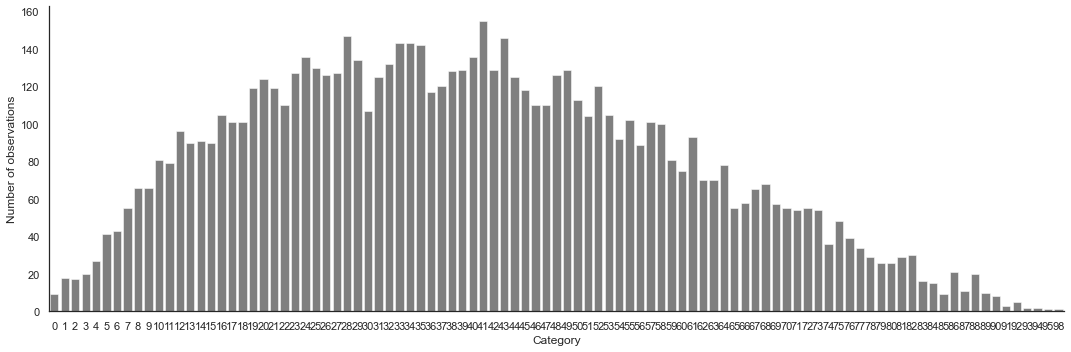

In [82]:
X_train = pd.read_csv(f"data/experiment_{exp_id}/train_data.csv")
X_test = pd.read_csv(f"data/experiment_{exp_id}/test_data.csv")
X = pd.concat([X_train, X_test], axis=0)
cat_count = X[hicard_var].value_counts()
fig = plt.figure(figsize=(15, 5))
_ = sns.barplot(x=cat_count.index, y=cat_count.values, color="black", alpha=0.5)
plt.ylabel("Number of observations")
plt.xlabel("Category")
plt.tight_layout()

In [83]:
train_scores, test_scores, plots, runtimes, fitted_models = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist="gaussian", random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(test_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 96.
Epoch 146: early stopping
79/79 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 76.
Epoch 126: early stopping


100%|██████████| 100/100 [00:04<00:00, 23.61it/s]


Restoring model weights from the end of the best epoch: 136.
Epoch 186: early stopping


100%|██████████| 100/100 [00:03<00:00, 25.30it/s]


MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat  0.2057 0.1765 0.2571 0.2567 0.3610    0.1720   
GLM_one_hot     0.1598 0.1375 0.2027 0.2004 0.6104    0.0000   
GLM_GLMM_enc    0.1642 0.1398 0.2079 0.2054 0.5907    0.0638   
GBM_ignore_cat  0.1834 0.1575 0.2252 0.2287 0.4927    0.1606   
GBM_one_hot     0.1706 0.1466 0.2071 0.2118 0.5650    0.1345   
GBM_GLMM_enc    0.1397 0.1192 0.1763 0.1747 0.7039    0.0613   
NN_ee           0.1284 0.1089 0.1654 0.1607 0.7496    0.0276   
GBM_ee          0.1648 0.1393 0.2029 0.2057 0.5895    0.1288   
GLMM            0.1601 0.1370 0.2028 0.2006 0.6097    0.0374   
GPBoost         0.1513 0.1288 0.1961 0.1890 0.6537    0.0284   
LMMNN           0.1235 0.1054 0.1581 0.1543 0.7691    0.0245   
GLMMNet         0.1381 0.1186 0.1747 0.1725 0.7113    0.0455   
GLMMNet_dropout 0.1464 0.1243 0.1944 0.1831 0.6748    0.0769   

                 RMSE_avg_weighted   CRPS     NLL  
GLM_ignore_cat              0.1603 0.1451  0.0590  
GLM_one_hot                 0.0000 0.1131 -0.1884  
GLM_GLMM_enc                0.0244 0.1160 -0.1637  
GBM_ignore_cat              0.1518 0.1292 -0.0564  
GBM_one_hot                 0.1129 0.1200 -0.1333  
GBM_GLMM_enc                0.0286 0.0986 -0.3256  
NN_ee                       0.0154 0.0905 -0.4095  
GBM_ee                      0.1093 0.1161 -0.1623  
GLMM                        0.0079 0.1132 -0.1874  
GPBoost                     0.0071 0.1068 -0.2472  
LMMNN                       0.0049 0.0872 -0.4477  
GLMMNet                     0.0193 0.0974 -0.3379  
GLMMNet_dropout             0.0562 0.1035 -0.2787

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat  0.2057 0.1745 0.2460 0.2570 0.3748    0.1655   
GLM_one_hot     0.1651 0.1394 0.2025 0.2066 0.5959    0.0915   
GLM_GLMM_enc    0.1660 0.1410 0.2021 0.2071 0.5942    0.0823   
GBM_ignore_cat  0.1895 0.1562 0.2238 0.2396 0.4566    0.1646   
GBM_one_hot     0.1759 0.1444 0.2070 0.2217 0.5348    0.1292   
GBM_GLMM_enc    0.1493 0.1284 0.1851 0.1866 0.6703    0.0782   
NN_ee           0.1504 0.1250 0.1840 0.1888 0.6627    0.0808   
GBM_ee          0.1709 0.1426 0.2008 0.2158 0.5593    0.1311   
GLMM            0.1647 0.1399 0.2017 0.2061 0.5982    0.0780   
GPBoost         0.1654 0.1384 0.2052 0.2081 0.5900    0.0782   
LMMNN           0.1524 0.1273 0.1892 0.1917 0.6523    0.0732   
GLMMNet         0.1498 0.1300 0.1890 0.1865 0.6707    0.0693   
GLMMNet_dropout 0.1557 0.1344 0.2030 0.1943 0.6427    0.0920   

                 RMSE_avg_weighted   CRPS     NLL  
GLM_ignore_cat              0.1608 0.1450  0.0603  
GLM_one_hot                 0.0493 0.1167 -0.1579  
GLM_GLMM_enc                0.0513 0.1170 -0.1558  
GBM_ignore_cat              0.1585 0.1348 -0.0097  
GBM_one_hot                 0.1183 0.1250 -0.0875  
GBM_GLMM_enc                0.0506 0.1054 -0.2596  
NN_ee                       0.0477 0.1064 -0.2483  
GBM_ee                      0.1163 0.1215 -0.1145  
GLMM                        0.0472 0.1164 -0.1604  
GPBoost                     0.0504 0.1174 -0.1411  
LMMNN                       0.0440 0.1089 -0.2010  
GLMMNet                     0.0461 0.1054 -0.2563  
GLMMNet_dropout             0.0720 0.1099 -0.2193

Runtime (sec)
GLM_ignore_cat          0.0028
GLM_one_hot             0.2410
GLM_GLMM_enc            0.0111
GBM_ignore_cat          0.4822
GBM_one_hot             0.3170
GBM_GLMM_enc            0.2916
NN_ee                  21.4348
GBM_ee                  0.1882
LMMNN                  23.7920
GLMMNet                27.4691
GLMMNet_dropout        39.7789

**Observations**:
Results are mostly consistent with those from Experiment #1.
- NNs (`NN_ee`, `LMMNN`) are clear winners whenever signal in the data is strong enough.
- Followed by `GBM_ee`, `GPBoost` and `GBM_GLMM_enc`.
    - Embeddings are transferable & provide significant benefit when the NN from which they are extracted is good.
    - GLMM encoding can perform reasonably well even under skewed distributions. Better than plain GLMM, suggesting the non-linearity in GBM is more important than getting the random effects structure 100% correct.

In [84]:
g_re = gridplot([
    plots["GLMM_encodings"], plots["GLMM_RE_pred"], plots["GPBoost_RE_pred"], 
    plots["LMMNN_RE_pred"], plots["GLMMNet_RE_pred"], plots["GLMMNet_dropout_RE_pred"],
    ], ncols=3, height=300, width=300)
bop.show(g_re)

#### Plot Ridgeline

100%|██████████| 100/100 [00:04<00:00, 21.10it/s]


79/79 [==============================] - 0s 3ms/step


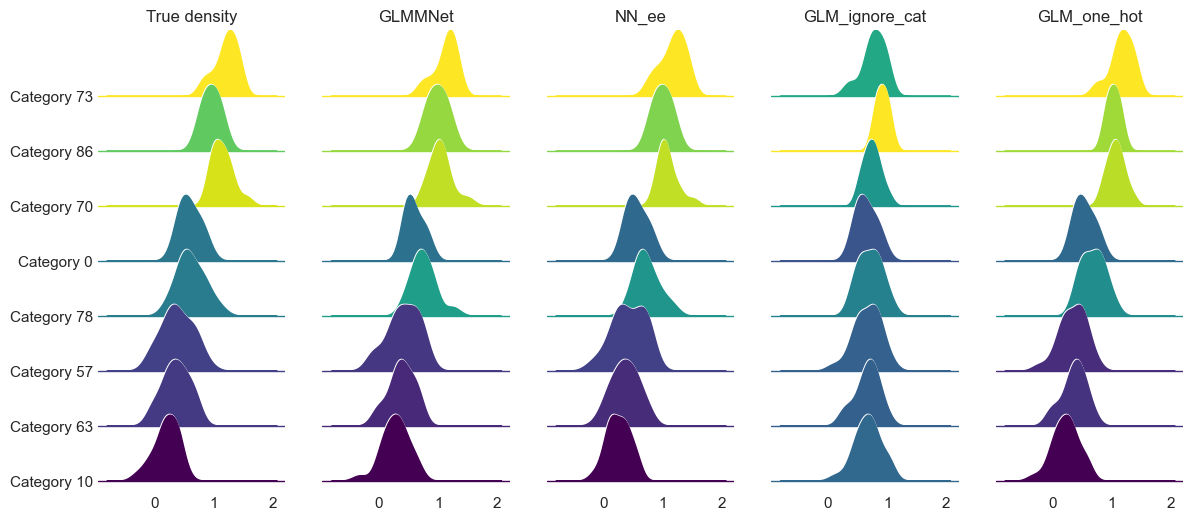

In [85]:
# To plot ridgelines, need to get the models' predictions
# Unpack data
X_train, y_train, y_true_train = sim_data["train"]
X_test, y_test, y_true_test = sim_data["test"]
Zu = sim_data["Zu"]

# Load the fitted models
X_train_ic = ignore_cat_encoder.fit_transform(X_train)
X_test_ic = ignore_cat_encoder.transform(X_test)
GLM_ignore_cat = fitted_models["GLM_ignore_cat"]

one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ohe = one_hot_encoder.fit_transform(X_train)
X_test_ohe = one_hot_encoder.transform(X_test)
GLM_one_hot = fitted_models["GLM_one_hot"]

X_train_ct = pd.DataFrame(ct_nn.fit_transform(X_train), columns=colnames)
X_test_ct = pd.DataFrame(ct_nn.transform(X_test), columns=colnames)
X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])
NN_ee = fitted_models["NN_ee"]

one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
X_test_ct_ohe = one_hot.transform(X_test_ct)
glmmnet = fitted_models["GLMMNet"]

# To make predictions, we call the model multiple times and average the results
# This is because the random effects are sampled from the posterior (in the DenseVariational layer).
y_pred_test = predict_glmmnet(glmmnet, X_test_ct_ohe, hicard_var)

dpi = 100
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(1400/dpi, 600/dpi), dpi=dpi)

test_data = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y_test, columns=["y"]),
    pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)
ranked_cats = test_data.groupby("category").mean().sort_values("y").index.to_list()
selected_cats = ranked_cats[:3] + ranked_cats[len(ranked_cats)//2:len(ranked_cats)//2+2] + ranked_cats[-3:]
p_min, p_max = y_true_test.min(), y_true_test.max()
plot_ridgeline(X_test["category"], y_true_test, selected_cats, axes[0], "True density")
plot_ridgeline(X_test["category"], y_pred_test, selected_cats, axes[1], "GLMMNet", ylabel=False, p_min=p_min, p_max=p_max)
NN_ee_y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
plot_ridgeline(X_test["category"], NN_ee_y_pred_test, selected_cats, axes[2], "NN_ee", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GLM_ignore_cat.predict(X_test_ic), selected_cats, axes[3], "GLM_ignore_cat", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GLM_one_hot.predict(X_test_ohe), selected_cats, axes[4], "GLM_one_hot", ylabel=False, p_min=p_min, p_max=p_max)

plt.show()
fig.savefig(f"figures/experiment_{exp_id}/ridgeline.pdf")

### Experiment #4

In [86]:
# Configure simulation parameters
exp_id = 4                         # experiment id
sig2noise = np.array([4, 1, 2])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gaussian"                # distribution of the response variable y
inverse_link = lambda x: x         # inverse of the identity link
cat_dist = "balanced"              # distribution of the categorical variable
random_seed = 42 + exp_id          # random seed for reproducibility
log_plot = True                    # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network (entity embedding model)

In [87]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, n_train=n_train, n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True,
)

In [88]:
train_scores, test_scores, plots, runtimes, fitted_models = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist=y_dist, random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(test_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 21.
Epoch 71: early stopping
79/79 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 107.
Epoch 157: early stopping


100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Restoring model weights from the end of the best epoch: 348.
Epoch 398: early stopping


100%|██████████| 100/100 [00:04<00:00, 24.10it/s]


MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat  0.2653 0.2232 0.3052 0.3329 0.2029    0.1398   
GLM_one_hot     0.2386 0.2003 0.2803 0.3013 0.3470    0.0000   
GLM_GLMM_enc    0.2445 0.2041 0.2846 0.3088 0.3141    0.0290   
GBM_ignore_cat  0.2502 0.2063 0.2908 0.3148 0.2874    0.1359   
GBM_one_hot     0.2438 0.2026 0.2811 0.3057 0.3277    0.1033   
GBM_GLMM_enc    0.2301 0.1934 0.2681 0.2897 0.3964    0.0374   
NN_ee           0.2317 0.1967 0.2775 0.2926 0.3841    0.0285   
GBM_ee          0.2444 0.2035 0.2793 0.3072 0.3213    0.1117   
GLMM            0.2388 0.2007 0.2803 0.3017 0.3454    0.0129   
GPBoost         0.2242 0.1863 0.2605 0.2838 0.4206    0.0114   
LMMNN           0.2138 0.1784 0.2521 0.2697 0.4769    0.0082   
GLMMNet         0.2228 0.1887 0.2674 0.2790 0.4401    0.0282   
GLMMNet_dropout 0.2273 0.1897 0.2723 0.2862 0.4108    0.0483   

                 RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat              0.1414 0.1877 0.3191  
GLM_one_hot                 0.0000 0.1696 0.2193  
GLM_GLMM_enc                0.0289 0.1738 0.2439  
GBM_ignore_cat              0.1374 0.1774 0.2630  
GBM_one_hot                 0.1039 0.1725 0.2339  
GBM_GLMM_enc                0.0375 0.1633 0.1800  
NN_ee                       0.0280 0.1649 0.1901  
GBM_ee                      0.1126 0.1732 0.2387  
GLMM                        0.0129 0.1699 0.2207  
GPBoost                     0.0114 0.1599 0.1596  
LMMNN                       0.0082 0.1518 0.1093  
GLMMNet                     0.0277 0.1575 0.1428  
GLMMNet_dropout             0.0476 0.1613 0.1680

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat  0.2623 0.2165 0.3085 0.3300 0.1976    0.1465   
GLM_one_hot     0.2427 0.2034 0.2905 0.3054 0.3127    0.0711   
GLM_GLMM_enc    0.2430 0.2050 0.2867 0.3055 0.3123    0.0718   
GBM_ignore_cat  0.2550 0.2150 0.2934 0.3203 0.2437    0.1450   
GBM_one_hot     0.2477 0.2073 0.2892 0.3107 0.2886    0.1113   
GBM_GLMM_enc    0.2366 0.1976 0.2736 0.2967 0.3514    0.0755   
NN_ee           0.2389 0.1978 0.2849 0.3017 0.3292    0.0772   
GBM_ee          0.2487 0.2093 0.2891 0.3120 0.2824    0.1228   
GLMM            0.2425 0.2034 0.2872 0.3053 0.3130    0.0702   
GPBoost         0.2405 0.2038 0.2875 0.3019 0.3283    0.0693   
LMMNN           0.2421 0.1994 0.2855 0.3036 0.3205    0.0676   
GLMMNet         0.2387 0.1989 0.2785 0.3017 0.3293    0.0744   
GLMMNet_dropout 0.2375 0.1984 0.2906 0.2987 0.3423    0.0864   

                 RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat              0.1439 0.1856 0.3102  
GLM_one_hot                 0.0713 0.1722 0.2328  
GLM_GLMM_enc                0.0719 0.1722 0.2331  
GBM_ignore_cat              0.1421 0.1805 0.2806  
GBM_one_hot                 0.1112 0.1753 0.2500  
GBM_GLMM_enc                0.0756 0.1674 0.2038  
NN_ee                       0.0769 0.1700 0.2206  
GBM_ee                      0.1205 0.1760 0.2543  
GLMM                        0.0703 0.1721 0.2326  
GPBoost                     0.0696 0.1706 0.2243  
LMMNN                       0.0677 0.1725 0.2513  
GLMMNet                     0.0741 0.1701 0.2306  
GLMMNet_dropout             0.0863 0.1683 0.2107

Runtime (sec)
GLM_ignore_cat          0.0053
GLM_one_hot             0.1594
GLM_GLMM_enc            0.0239
GBM_ignore_cat          0.3920
GBM_one_hot             0.3455
GBM_GLMM_enc            0.2469
NN_ee                  11.0533
GBM_ee                  0.2532
LMMNN                  24.1628
GLMMNet                31.0303
GLMMNet_dropout        78.2343

In [89]:
# Redo prediction plots
# bop.show(plots["GBM_one_hot"])
# bop.show(plots["GLMM"])
# bop.show(plots["NN_ee"])
bop.show(plots["GLMMNet_dropout"])

In [90]:
g_re = gridplot([
    plots["GLMM_encodings"], plots["GLMM_RE_pred"], 
    plots["GLMMNet_RE_pred"], plots["GLMMNet_dropout_RE_pred"],
    ], ncols=2, height=300, width=300)
bop.show(g_re)

#### Plot Ridgeline

100%|██████████| 100/100 [00:04<00:00, 20.78it/s]


79/79 [==============================] - 0s 3ms/step


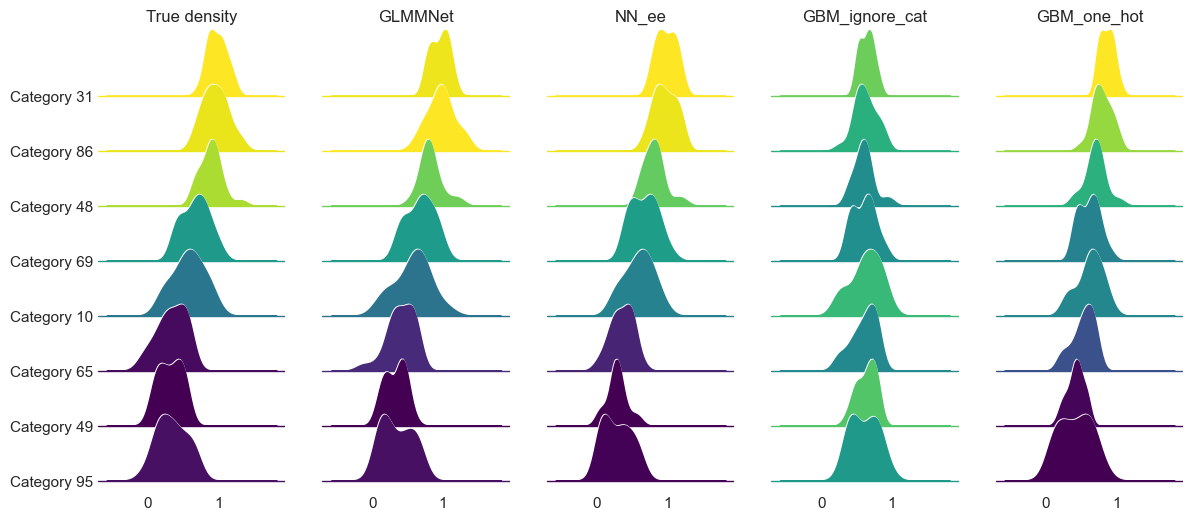

In [91]:
# To plot ridgelines, need to get the models' predictions
# Unpack data
X_train, y_train, y_true_train = sim_data["train"]
X_test, y_test, y_true_test = sim_data["test"]
Zu = sim_data["Zu"]

ignore_cat_encoder = make_column_transformer(
    ("drop", [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ic = ignore_cat_encoder.fit_transform(X_train)
X_test_ic = ignore_cat_encoder.transform(X_test)

one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ohe = one_hot_encoder.fit_transform(X_train)
X_test_ohe = one_hot_encoder.transform(X_test)

ct_nn = make_column_transformer(
    (ce.ordinal.OrdinalEncoder(handle_unknown="value"), [hicard_var]), # "value" encodes unknown categories as "-1"
    (MinMaxScaler(feature_range=(0, 1)), x_num),
)
X_train_ct = pd.DataFrame(ct_nn.fit_transform(X_train), columns=colnames)
X_test_ct = pd.DataFrame(ct_nn.transform(X_test), columns=colnames)
X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])

one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
X_test_ct_ohe = one_hot.transform(X_test_ct)

# Get the fitted models
NN_ee = fitted_models["NN_ee"]
glmmnet = fitted_models["GLMMNet"]
GBM_one_hot = fitted_models["GBM_one_hot"]
GBM_ignore_cat = fitted_models["GBM_ignore_cat"]

# To make predictions, we call the model multiple times and average the results
# This is because the random effects are sampled from the posterior (in the DenseVariational layer).
y_pred_test = predict_glmmnet(glmmnet, X_test_ct_ohe, hicard_var)

dpi = 100
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(1400/dpi, 600/dpi), dpi=dpi)
test_data = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y_test, columns=["y"]),
    pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)
ranked_cats = test_data.groupby("category").mean().sort_values("y").index.to_list()
selected_cats = ranked_cats[:3] + ranked_cats[len(ranked_cats)//2:len(ranked_cats)//2+2] + ranked_cats[-3:]
p_min, p_max = y_true_test.min(), y_true_test.max()
plot_ridgeline(X_test["category"], y_true_test, selected_cats, axes[0], "True density")
plot_ridgeline(X_test["category"], y_pred_test, selected_cats, axes[1], "GLMMNet", ylabel=False, p_min=p_min, p_max=p_max)
NN_ee_y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
plot_ridgeline(X_test["category"], NN_ee_y_pred_test, selected_cats, axes[2], "NN_ee", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GBM_ignore_cat.predict(X_test_ic), selected_cats, axes[3], "GBM_ignore_cat", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GBM_one_hot.predict(X_test_ohe), selected_cats, axes[4], "GBM_one_hot", ylabel=False, p_min=p_min, p_max=p_max)

plt.show()
fig.savefig(f"figures/experiment_{exp_id}/ridgeline.pdf")

### Experiment #5

**Observations**:
- More typical of what we see with real insurance data. Differences in performance are small.
- As often observed in practice with tabular data, GBM shows a marginal but consistent advantage over GLM and NN.
- Models with random effects (including GLMM encoded models) can capture the between-category differences better than the entity embeddings.

RE predictions are much worse compared to experiment #1 (as one would expect, the models would have picked up more random noise).

In [94]:
# Configure simulation parameters
exp_id = 5                         # experiment id
sig2noise = np.array([8, 1, 4])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gaussian"                # distribution of the response variable y
inverse_link = lambda x: x         # inverse of the log link
cat_dist = "balanced"              # distribution of the categorical variable
random_seed = 42 + exp_id          # random seed for reproducibility
log_plot = True                    # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network (entity embedding model)

In [95]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, n_train=n_train, n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True,
)

In [96]:
train_scores, test_scores, plots, runtimes, fitted_models = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist=y_dist, random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(test_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 34.
Epoch 84: early stopping
79/79 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 107.
Epoch 157: early stopping


100%|██████████| 100/100 [00:04<00:00, 24.23it/s]


Restoring model weights from the end of the best epoch: 412.
Epoch 462: early stopping


100%|██████████| 100/100 [00:04<00:00, 23.84it/s]


MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat  0.2632 0.2248 0.3017 0.3303 0.2300    0.0762   
GLM_one_hot     0.2565 0.2199 0.2963 0.3215 0.2705    0.0000   
GLM_GLMM_enc    0.2613 0.2241 0.2997 0.3279 0.2412    0.0433   
GBM_ignore_cat  0.2470 0.2105 0.2832 0.3089 0.3267    0.0721   
GBM_one_hot     0.2462 0.2099 0.2835 0.3080 0.3308    0.0621   
GBM_GLMM_enc    0.2447 0.2067 0.2873 0.3064 0.3377    0.0475   
NN_ee           0.2422 0.2045 0.2823 0.3044 0.3461    0.0282   
GBM_ee          0.2456 0.2077 0.2844 0.3072 0.3342    0.0615   
GLMM            0.2574 0.2209 0.2953 0.3226 0.2656    0.0284   
GPBoost         0.2426 0.2092 0.2862 0.3036 0.3494    0.0270   
LMMNN           0.2261 0.1902 0.2659 0.2859 0.4231    0.0161   
GLMMNet         0.2392 0.2026 0.2755 0.2998 0.3659    0.0346   
GLMMNet_dropout 0.2477 0.2093 0.3009 0.3113 0.3162    0.0884   

                 RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat              0.0756 0.1863 0.3113  
GLM_one_hot                 0.0000 0.1814 0.2843  
GLM_GLMM_enc                0.0425 0.1850 0.3040  
GBM_ignore_cat              0.0713 0.1744 0.2442  
GBM_one_hot                 0.0613 0.1738 0.2412  
GBM_GLMM_enc                0.0464 0.1729 0.2360  
NN_ee                       0.0273 0.1715 0.2296  
GBM_ee                      0.0608 0.1734 0.2386  
GLMM                        0.0278 0.1820 0.2877  
GPBoost                     0.0263 0.1714 0.2271  
LMMNN                       0.0158 0.1608 0.1690  
GLMMNet                     0.0343 0.1692 0.2155  
GLMMNet_dropout             0.0876 0.1754 0.2519

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat  0.2644 0.2237 0.3041 0.3313 0.2220    0.1016   
GLM_one_hot     0.2605 0.2231 0.2977 0.3256 0.2486    0.0798   
GLM_GLMM_enc    0.2603 0.2184 0.2977 0.3255 0.2491    0.0797   
GBM_ignore_cat  0.2545 0.2150 0.2902 0.3203 0.2730    0.0982   
GBM_one_hot     0.2531 0.2137 0.2873 0.3186 0.2804    0.0920   
GBM_GLMM_enc    0.2510 0.2104 0.2834 0.3158 0.2931    0.0817   
NN_ee           0.2596 0.2192 0.3049 0.3249 0.2519    0.0849   
GBM_ee          0.2531 0.2150 0.2853 0.3185 0.2809    0.0914   
GLMM            0.2603 0.2200 0.2989 0.3257 0.2483    0.0805   
GPBoost         0.2560 0.2130 0.2886 0.3215 0.2673    0.0788   
LMMNN           0.2727 0.2321 0.3096 0.3416 0.1729    0.0874   
GLMMNet         0.2587 0.2180 0.2846 0.3245 0.2538    0.0863   
GLMMNet_dropout 0.2598 0.2207 0.2981 0.3288 0.2337    0.1148   

                 RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat              0.0999 0.1868 0.3142  
GLM_one_hot                 0.0789 0.1839 0.2968  
GLM_GLMM_enc                0.0785 0.1838 0.2965  
GBM_ignore_cat              0.0968 0.1805 0.2803  
GBM_one_hot                 0.0902 0.1795 0.2752  
GBM_GLMM_enc                0.0803 0.1781 0.2663  
NN_ee                       0.0844 0.1835 0.2946  
GBM_ee                      0.0900 0.1795 0.2749  
GLMM                        0.0791 0.1838 0.2970  
GPBoost                     0.0773 0.1815 0.2870  
LMMNN                       0.0855 0.1951 0.4023  
GLMMNet                     0.0849 0.1837 0.3076  
GLMMNet_dropout             0.1147 0.1851 0.3066

Runtime (sec)
GLM_ignore_cat          0.0097
GLM_one_hot             0.2103
GLM_GLMM_enc            0.0214
GBM_ignore_cat          0.3548
GBM_one_hot             0.2784
GBM_GLMM_enc            0.1788
NN_ee                  12.4656
GBM_ee                  0.1834
LMMNN                  23.2418
GLMMNet                30.6934
GLMMNet_dropout        90.2150

100%|██████████| 100/100 [00:04<00:00, 21.96it/s]


79/79 [==============================] - 0s 2ms/step


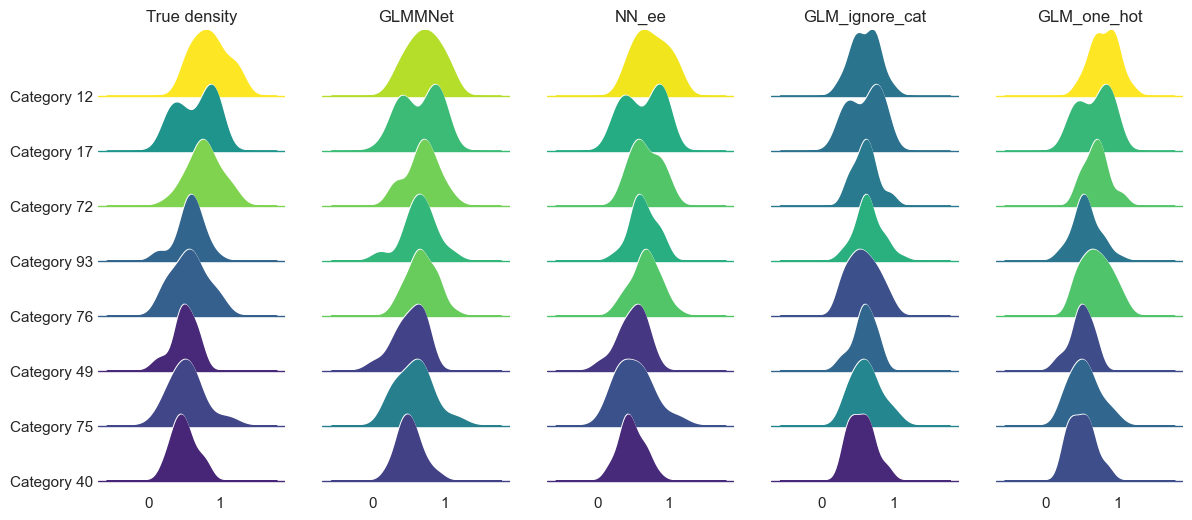

In [97]:
# To plot ridgelines, need to get the models' predictions
# Unpack data
X_train, y_train, y_true_train = sim_data["train"]
X_test, y_test, y_true_test = sim_data["test"]
Zu = sim_data["Zu"]

# Refit models
X_train_ic = ignore_cat_encoder.fit_transform(X_train)
X_test_ic = ignore_cat_encoder.transform(X_test)
GLM_ignore_cat = fitted_models["GLM_ignore_cat"]

one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ohe = one_hot_encoder.fit_transform(X_train)
X_test_ohe = one_hot_encoder.transform(X_test)
GLM_one_hot = fitted_models["GLM_one_hot"]

X_train_ct = pd.DataFrame(ct_nn.fit_transform(X_train), columns=colnames)
X_test_ct = pd.DataFrame(ct_nn.transform(X_test), columns=colnames)
X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])
NN_ee = fitted_models["NN_ee"]

one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
X_test_ct_ohe = one_hot.transform(X_test_ct)
glmmnet = fitted_models["GLMMNet"]

# To make predictions, we call the model multiple times and average the results
# This is because the random effects are sampled from the posterior (in the DenseVariational layer).
y_pred_test = predict_glmmnet(glmmnet, X_test_ct_ohe, hicard_var)

dpi = 100
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(1400/dpi, 600/dpi), dpi=dpi)

test_data = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y_test, columns=["y"]),
    pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)
ranked_cats = test_data.groupby("category").mean().sort_values("y").index.to_list()
selected_cats = ranked_cats[:3] + ranked_cats[len(ranked_cats)//2:len(ranked_cats)//2+2] + ranked_cats[-3:]
p_min, p_max = y_true_test.min(), y_true_test.max()
plot_ridgeline(X_test["category"], y_true_test, selected_cats, axes[0], "True density")
plot_ridgeline(X_test["category"], y_pred_test, selected_cats, axes[1], "GLMMNet", ylabel=False, p_min=p_min, p_max=p_max)
NN_ee_y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
plot_ridgeline(X_test["category"], NN_ee_y_pred_test, selected_cats, axes[2], "NN_ee", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GLM_ignore_cat.predict(X_test_ic), selected_cats, axes[3], "GLM_ignore_cat", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GLM_one_hot.predict(X_test_ohe), selected_cats, axes[4], "GLM_one_hot", ylabel=False, p_min=p_min, p_max=p_max)

plt.show()
# fig.savefig(f"figures/experiment_{exp_id}/ridgeline.pdf")

In [98]:
g_re = gridplot([
    plots["GLMM_encodings"], plots["GLMM_RE_pred"], 
    plots["GPBoost_RE_pred"], plots["GLMMNet_RE_pred"],
    plots["GLMMNet_dropout_RE_pred"]
    ], ncols=3, height=300, width=300)
bop.show(g_re)

### Experiment #6

In [100]:
# Configure simulation parameters
exp_id = 6                         # experiment id
sig2noise = np.array([8, 1, 4])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gamma"                   # distribution of the response variable y
inverse_link = np.exp              # inverse of the log link
cat_dist = "skewed"                # distribution of the categorical variable
random_seed = 42 + exp_id          # random seed for reproducibility
log_plot = True                    # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network (entity embedding model)

In [101]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, n_train=n_train,  n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True,
)

In [102]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


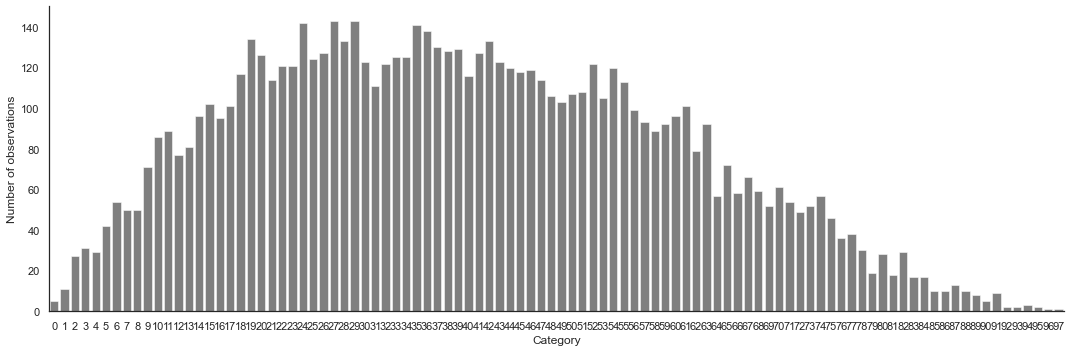

In [103]:
X_train = pd.read_csv(f"data/experiment_{exp_id}/train_data.csv")
X_test = pd.read_csv(f"data/experiment_{exp_id}/test_data.csv")
X = pd.concat([X_train, X_test], axis=0)
cat_count = X[hicard_var].value_counts()
fig = plt.figure(figsize=(15, 5))
_ = sns.barplot(x=cat_count.index, y=cat_count.values, color="black", alpha=0.5)
plt.ylabel("Number of observations")
plt.xlabel("Category")
plt.tight_layout()

In [104]:
# Not the best practice..
# but there seems no other way to suppress warnings around unknown categories being transformed to all zeros,
# even though they have been told to handle_unknown="ignore"
import warnings
warnings.simplefilter("ignore", UserWarning)

In [105]:
train_scores, test_scores, plots, runtimes, fitted_models = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist=y_dist, random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(test_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 56.
Epoch 106: early stopping
79/79 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 38.
Epoch 88: early stopping


100%|██████████| 100/100 [00:04<00:00, 23.94it/s]


Restoring model weights from the end of the best epoch: 159.
Epoch 209: early stopping


100%|██████████| 100/100 [00:04<00:00, 23.70it/s]


MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat  0.5104 0.4116 0.2251 0.6674 0.2082    0.2423   
GLM_one_hot     0.4893 0.3917 0.2142 0.6388 0.2745    0.0663   
GLM_GLMM_enc    0.4988 0.3997 0.2196 0.6510 0.2467    0.1706   
GBM_ignore_cat  0.4747 0.3836 0.2088 0.6212 0.3139    0.2302   
GBM_one_hot     0.4729 0.3879 0.2071 0.6179 0.3212    0.2108   
GBM_GLMM_enc    0.4635 0.3777 0.2033 0.6049 0.3496    0.1659   
NN_ee           0.4641 0.3716 0.2020 0.6049 0.3496    0.0870   
GBM_ee          0.4732 0.3844 0.2082 0.6197 0.3173    0.2175   
GLMM            0.4909 0.3912 0.2159 0.6409 0.2699    0.1442   
GPBoost         0.4871 0.3960 0.2146 0.6380 0.2763    0.2301   
GLMMNet         0.4675 0.3721 0.2043 0.6102 0.3381    0.1641   
GLMMNet_dropout 0.4599 0.3629 0.2026 0.6103 0.3379    0.1773   

                 RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat              0.1890 0.3612 0.9257  
GLM_one_hot                 0.0200 0.3456 0.8815  
GLM_GLMM_enc                0.0760 0.3525 0.9007  
GBM_ignore_cat              0.1830 0.3361 0.8547  
GBM_one_hot                 0.1480 0.3343 0.8490  
GBM_GLMM_enc                0.0836 0.3274 0.8286  
NN_ee                       0.0511 0.3276 0.8296  
GBM_ee                      0.1685 0.3353 0.8527  
GLMM                        0.0521 0.3468 0.8847  
GPBoost                     0.1809 0.3454 0.8827  
GLMMNet                     0.0761 0.3302 0.8360  
GLMMNet_dropout             0.1237 0.3302 0.8354

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat  0.5243 0.4241 0.2405 0.6858 0.2143    0.3081   
GLM_one_hot     0.5081 0.4088 0.2264 0.6649 0.2616    0.2602   
GLM_GLMM_enc    0.5106 0.4068 0.2277 0.6669 0.2571    0.2619   
GBM_ignore_cat  0.5067 0.4135 0.2254 0.6640 0.2634    0.3051   
GBM_one_hot     0.5038 0.4111 0.2248 0.6598 0.2729    0.2927   
GBM_GLMM_enc    0.4938 0.4018 0.2213 0.6458 0.3034    0.2616   
NN_ee           0.4983 0.4062 0.2228 0.6509 0.2923    0.2526   
GBM_ee          0.5047 0.4106 0.2235 0.6612 0.2697    0.2942   
GLMM            0.5080 0.4097 0.2268 0.6645 0.2624    0.2644   
GPBoost         0.5060 0.4123 0.2256 0.6636 0.2644    0.2996   
GLMMNet         0.4954 0.4053 0.2227 0.6469 0.3010    0.2697   
GLMMNet_dropout 0.4879 0.3862 0.2180 0.6486 0.2974    0.2713   

                 RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat              0.2366 0.3687 0.9381  
GLM_one_hot                 0.1753 0.3578 0.9125  
GLM_GLMM_enc                0.1826 0.3588 0.9135  
GBM_ignore_cat              0.2369 0.3570 0.9082  
GBM_one_hot                 0.2152 0.3545 0.9017  
GBM_GLMM_enc                0.1781 0.3472 0.8821  
NN_ee                       0.1749 0.3512 0.8986  
GBM_ee                      0.2284 0.3554 0.9040  
GLMM                        0.1735 0.3575 0.9109  
GPBoost                     0.2312 0.3568 0.9080  
GLMMNet                     0.1729 0.3486 0.8914  
GLMMNet_dropout             0.1892 0.3490 0.8878

Runtime (sec)
GLM_ignore_cat          0.6905
GLM_one_hot            19.1912
GLM_GLMM_enc            0.2255
GBM_ignore_cat          0.3753
GBM_one_hot             0.2844
GBM_GLMM_enc            0.1892
NN_ee                  15.3122
GBM_ee                  0.2299
GLMMNet                20.7257
GLMMNet_dropout        47.2970

In [106]:
g_re = gridplot([
    plots["GLMM_encodings"], plots["GLMM_RE_pred"], 
    plots["GPBoost_RE_pred"],
    plots["GLMMNet_RE_pred"], plots["GLMMNet_dropout_RE_pred"]
    ], ncols=3, height=300, width=300)
bop.show(g_re)

100%|██████████| 1000/1000 [00:51<00:00, 19.42it/s]


79/79 [==============================] - 0s 3ms/step


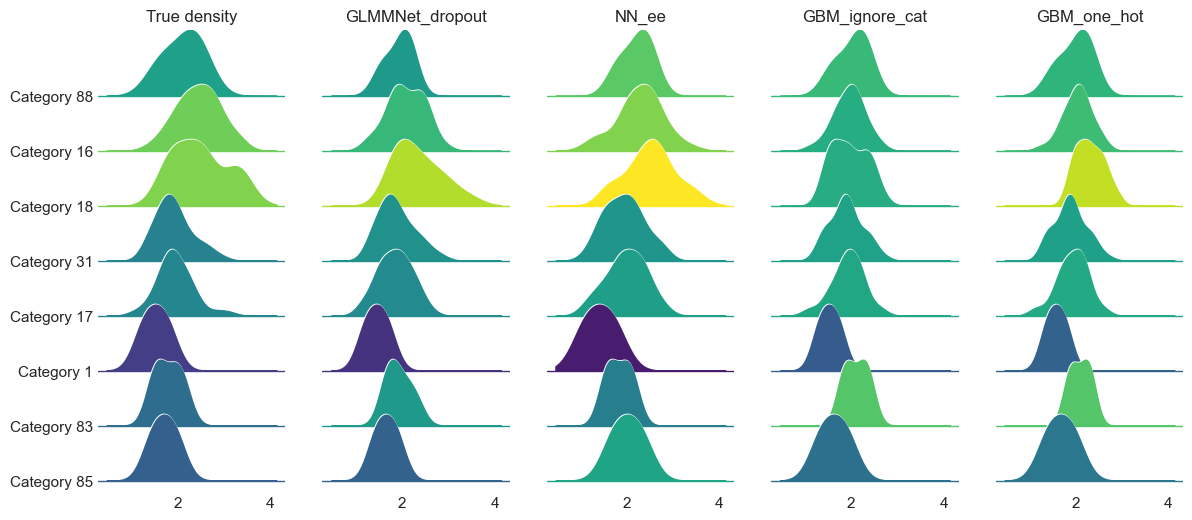

In [107]:
# To plot ridgelines, need to get the models' predictions
# Unpack data
X_train, y_train, y_true_train = sim_data["train"]
X_test, y_test, y_true_test = sim_data["test"]
Zu = sim_data["Zu"]

ignore_cat_encoder = make_column_transformer(
    ("drop", [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ic = ignore_cat_encoder.fit_transform(X_train)
X_test_ic = ignore_cat_encoder.transform(X_test)

one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ohe = one_hot_encoder.fit_transform(X_train)
X_test_ohe = one_hot_encoder.transform(X_test)

ct_nn = make_column_transformer(
    (ce.ordinal.OrdinalEncoder(handle_unknown="value"), [hicard_var]), # "value" encodes unknown categories as "-1"
    (MinMaxScaler(feature_range=(0, 1)), x_num),
)
X_train_ct = pd.DataFrame(ct_nn.fit_transform(X_train), columns=colnames)
X_test_ct = pd.DataFrame(ct_nn.transform(X_test), columns=colnames)
X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])

one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
X_test_ct_ohe = one_hot.transform(X_test_ct)

# Get the fitted models
NN_ee = fitted_models["NN_ee"]
glmmnet = fitted_models["GLMMNet"]
glmmnet_dropout = fitted_models["GLMMNet_dropout"]
GBM_one_hot = fitted_models["GBM_one_hot"]
GBM_ignore_cat = fitted_models["GBM_ignore_cat"]

# To make predictions, we call the model multiple times and average the results
# This is because the random effects are sampled from the posterior (in the DenseVariational layer).
n_prediction_samples = 1000
y_pred_test = predict_glmmnet(glmmnet_dropout, X_test_ct_ohe, hicard_var, n_prediction_samples)

dpi = 100
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(1400/dpi, 600/dpi), dpi=dpi)
test_data = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y_test, columns=["y"]),
    pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)
ranked_cats = test_data.groupby("category").mean().sort_values("y").index.to_list()
ranked_cats_by_freq = test_data.groupby("category").size().sort_values(ascending=False).index.to_list()
more_than_1_obs = test_data.groupby("category").count().query("y > 1").index.to_list()
ranked_cats = [cat for cat in ranked_cats if cat in more_than_1_obs]
ranked_cats_by_freq = [cat for cat in ranked_cats_by_freq if cat in more_than_1_obs]
selected_cats = ranked_cats[:3] + ranked_cats[len(ranked_cats)//2:len(ranked_cats)//2+2] + ranked_cats[-3:]
# selected_cats = ranked_cats_by_freq[:3] + ranked_cats_by_freq[len(ranked_cats_by_freq)//2:len(ranked_cats_by_freq)//2+2] + ranked_cats_by_freq[-3:]
# selected_cats = ranked_cats_by_freq[:4] + ranked_cats_by_freq[-4:]
p_min, p_max = y_true_test.min(), y_true_test.max()
plot_ridgeline(X_test["category"], y_true_test, selected_cats, axes[0], "True density")
plot_ridgeline(X_test["category"], y_pred_test, selected_cats, axes[1], "GLMMNet_dropout", ylabel=False, p_min=p_min, p_max=p_max)
NN_ee_y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
plot_ridgeline(X_test["category"], NN_ee_y_pred_test, selected_cats, axes[2], "NN_ee", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GBM_ignore_cat.predict(X_test_ic), selected_cats, axes[3], "GBM_ignore_cat", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GBM_one_hot.predict(X_test_ohe), selected_cats, axes[4], "GBM_one_hot", ylabel=False, p_min=p_min, p_max=p_max)

plt.show()
fig.savefig(f"figures/experiment_{exp_id}/ridgeline.pdf")